<a href="https://colab.research.google.com/github/victory06/TFG/blob/master/Second.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploración con solo los datos de familias
Sin datos de control

In [ ]:
"""
Lee las bases de datos y comprueba si hay datos perdidos:
    - path_data: indica la ruta del archivo con la base de datos
    - path_names: indica la ruta del archivo con los nombres de las columnas (SNIPS)
"""
import pandas as pd
import numpy as np
import collections as col
import seaborn as sns
import matplotlib.pyplot as plt

#Declaramos semilla global para todos los modelos
np.random.seed(42)

def readDataTrios(path_data, path_names):
  data = pd.read_csv(path_data, sep=" ", header=None)
  names_col = pd.read_csv(path_names, sep=",", header=None)
  if data.isnull().values.any():
    print("Hay datos perdidos")
  else:
    print("No hay datos perdidos")

  # Tomamos los nombres de los snpis para nombrar las columnas
  # Añadimos los nombres "Family ID", "Gender" y "Affection Status" que faltan
  names_c = names_col.to_numpy()[:,:].astype('U13')
  # En la columna 0 estan los nombres de los SNIPS
  names_column = names_c[:,0]
  names_column = np.repeat(names_column,2)
  names_column = np.insert(names_column, 0, "Gender", axis=0)
  names_column = np.insert(names_column, 0, "Family ID", axis=0)

  df = data.to_numpy()[:,:].astype('U13')
  df = df.astype(int)
  # Predecimos el affection status
  y = df[:,5]
  # Borramos la columna que queremos predecir
  x_np = np.delete(df, 5, 1)
  # Como nombre de las columnas vamos a establecer el ID del inivididuo
  names_row = df[:,1]
  
  # Borramos los ID. No se puede entrenar con los ID porque entonces da 1
  # de accuracy: predice padres 0 e hijos 2 ignorando los SNIPS.
  # Hay que dejar solo el family code.
  x_np = np.delete(x_np, 1, 1)
  x_np = np.delete(x_np, 1, 1)
  x_np = np.delete(x_np, 1, 1)
  x_np = np.delete(x_np, 2, 1)

  x_df = pd.DataFrame(x_np,index=names_row, columns = names_column)
  y_df = pd.DataFrame(y).values.flatten()

  return x_df, y_df

def metricas(y_real, y_pred, etiquetas):
  clasf = classification_report(y_real, y_pred, target_names=etiquetas)
  print(clasf)
  return clasf

def explorarBD(x_train, x_test, x, y, y_train, y_test):
  print("Número de instancias y número de variables:", x.shape)
  print("Valores de clase:",pd.unique(y))
  print("Número de instancias para cada clase: ",col.Counter(y))
  print("Número de instancias para cada clase test: ",col.Counter(y_test))
  print("Número de instancias para cada clase train: ",col.Counter(y_train))
  print("Numero de instancias en entrenamiento: {}; y test: {}".format(len(x_train),len(x_test)))
  print()

  lista = col.Counter(y)
  valores = ["No afectados (Padres)", "Afectados (Hijos)"]
  plt.bar(valores, lista.values())
  plt.title("Número de casos en la base de datos. Tríos.")
  plt.show()

  print()

  fig = plt.figure()
  ax1 = fig.add_subplot(111)
  for i in range(0,len(x)):
    if y[i] == 2:
      ax1.scatter(x.iloc[i]['mitog6735a'][0], x.iloc[i]['mitog6735a'][1], s=10, c='b', marker="s", label='Hijos')
    else:
      ax1.scatter(x.iloc[i]['mitog6735a'][0], x.iloc[i]['mitog6735a'][1], s=10, c='r', marker="o", label='Padres')
  
  hand, labl = ax1.get_legend_handles_labels()
  handout=[]
  lablout=[]
  for h,l in zip(hand,labl):
      if l not in lablout:
          lablout.append(l)
          handout.append(h)
  fig.legend(handout, lablout)
  plt.title("Valores en mitog6735a")
  plt.show()

  print()

  fig2 = plt.figure()
  ax2 = fig2.add_subplot(111)
  for i in range(0,len(x)):
    if y[i] == 2:
      ax2.scatter(x.iloc[i]['mitog16392a'][0], x.iloc[i]['mitog16392a'][1], s=10, c='b', marker="s", label='Hijos')
    else:
      ax2.scatter(x.iloc[i]['mitog16392a'][0], x.iloc[i]['mitog16392a'][1], s=10, c='r', marker="o", label='Padres')
  
  hand, labl = ax2.get_legend_handles_labels()
  handout=[]
  lablout=[]
  for h,l in zip(hand,labl):
      if l not in lablout:
          lablout.append(l)
          handout.append(h)
  fig2.legend(handout, lablout)
  plt.title("Valores en mitog16392a")
  plt.show()

def f_importances(coef, names):
  imp = coef
  imp,names = zip(*sorted(zip(imp,names)))
  plt.barh(range(len(names)), imp, align='center')
  plt.yticks(range(len(names)), names)
  plt.show()


No hay datos perdidos
Número de instancias y número de variables: (2592, 278)
Valores de clase: [0 2]
Número de instancias para cada clase:  Counter({0: 1728, 2: 864})
Número de instancias para cada clase test:  Counter({0: 438, 2: 210})
Número de instancias para cada clase train:  Counter({0: 1290, 2: 654})
Numero de instancias en entrenamiento: 1944; y test: 648



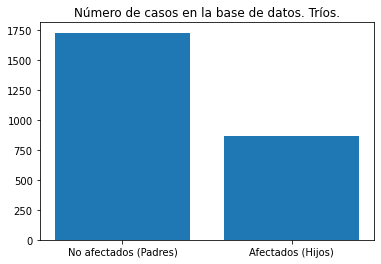

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f78244fdd40> (for post_execute):


KeyboardInterrupt: ignored

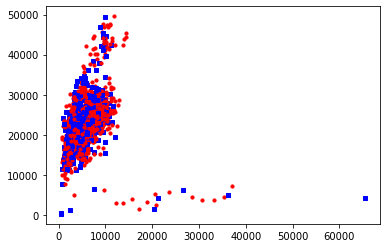

In [ ]:
from sklearn.model_selection import train_test_split
x, y= readDataTrios('/content/drive/MyDrive/TFG/Autism/AutismDuoChrom26.iou','/content/drive/MyDrive/TFG/Autism/Human1M-Duov3_B_PosSortedChrom26.cols')
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.25, random_state=42)
explorarBD(x_train, x_test, x, y , y_train, y_test)
x[:10]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier() 
knn.fit(x_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y_pred = knn.predict(x_test) # predicción de cada etiqueta 

# imprimimos la etiqueta calculada para los 20 primeros datos de X_test
print(y_pred[:20]) 
print(y_test[:20])

[0 2 2 0 0 0 0 0 0 2 0 0 0 0 0 0 2 2 0 0]
[0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 2 0 2 0 0]


In [ ]:
from sklearn.metrics import accuracy_score

acc_score = accuracy_score(y_test, y_pred)
print(acc_score)

0.5910493827160493


In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, x, y) #por defecto 5 particiones

print(scores) #los valores individuales de cada partición
print(np.mean(scores)) #la media de acierto global

[0.59537572 0.60500963 0.60810811 0.66409266 0.64478764]
0.6234747546886276


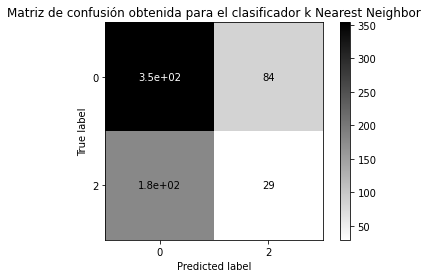

              precision    recall  f1-score   support

           0       0.66      0.81      0.73       438
           2       0.26      0.14      0.18       210

    accuracy                           0.59       648
   macro avg       0.46      0.47      0.45       648
weighted avg       0.53      0.59      0.55       648

La medida F1 para el clasificador KNeighborsClassifier es 0.1796


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

#el parámetro cmap utilizar un mapa de color en azules para ser cómodo a la vista
metrics.plot_confusion_matrix(knn, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador k Nearest Neighbor")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(knn.__class__.__name__,f1))

Coef. independiente: [-1.22281191e-08]
Coef. por variable: [[-2.51282597e-05 -4.68093098e-07  6.59371547e-05 -1.55718227e-05
  -3.62260510e-06  8.89235659e-06 -2.14159639e-05 -2.75154695e-05
  -1.48244487e-05 -1.85465808e-05 -1.31277675e-05  1.22255053e-05
  -1.85274820e-05  2.05324126e-05  3.58559675e-05 -3.23344884e-05
   2.55161758e-05  1.59440180e-05 -8.86512050e-05 -3.66588973e-06
  -3.73629341e-06 -3.36262867e-05 -3.08020597e-05 -3.90815654e-05
  -2.48651635e-05  2.19681803e-07  5.63569820e-05  2.33240618e-05
   3.74155117e-06 -4.33029622e-05  3.09591479e-05  1.21236805e-05
  -1.06603153e-05 -2.14057901e-05  3.41991483e-05  2.21619779e-05
  -1.29889675e-05  2.30201027e-06  5.15940686e-05 -1.31497595e-05
   3.48810082e-05  1.73062739e-05  8.83850494e-06 -1.80928017e-05
  -9.08081545e-06  1.12459611e-05 -3.86555925e-05  4.51417720e-06
   1.67244210e-05 -3.13984031e-06  4.61310541e-06  3.38862661e-05
  -4.07189042e-05  1.53852094e-05  4.25526603e-05  1.39908844e-05
   4.82774545e-05

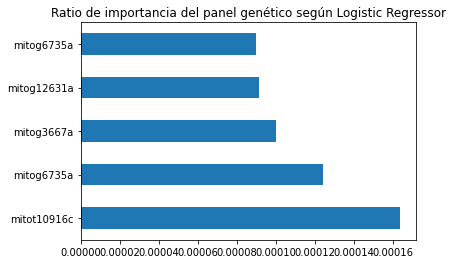


Valores de predicción originales (10 primeros):
[0 0 0 0 0 0 0 2 0 0]

Acierto de Logistic Regression en la partición de test: 0.6172839506172839


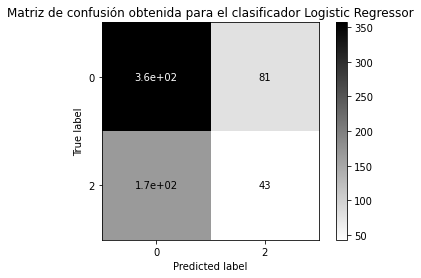

              precision    recall  f1-score   support

           0       0.68      0.82      0.74       438
           2       0.35      0.20      0.26       210

    accuracy                           0.62       648
   macro avg       0.51      0.51      0.50       648
weighted avg       0.57      0.62      0.59       648

La medida F1 para el clasificador LogisticRegression es 0.2575


In [ ]:
from sklearn import linear_model
from sklearn.preprocessing import normalize
lrm = linear_model.LogisticRegression()

lrm.fit(x_train, y_train)
print("Coef. independiente:",lrm.intercept_)
print("Coef. por variable:",lrm.coef_)
print()

importancia = np.abs(lrm.coef_[0]) #transformamos a una lista uni-dimensional
importancia_norm = normalize(importancia[:,np.newaxis], axis=0).ravel()
#Se representan las 5 más importantes según valor absoluto
(pd.Series(importancia, index=x_train.columns).nlargest(5).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Logistic Regressor")
plt.show()
print()

y_pred = lrm.predict(x_test)

print("Valores de predicción originales (10 primeros):")
print(y_pred[:10])
print()

acc_score = accuracy_score(y_test, y_pred)
print("Acierto de Logistic Regression en la partición de test:", acc_score)

metrics.plot_confusion_matrix(lrm, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Logistic Regressor")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(lrm.__class__.__name__,f1))


In [ ]:
from sklearn import tree

dt = tree.DecisionTreeClassifier()
dt.fit(x_train, y_train)

y_pred = dt.predict(x_test)

acc_score = accuracy_score(y_test, y_pred)
print("Acierto de DT en la partición de test:", acc_score)

Acierto de DT en la partición de test: 0.595679012345679


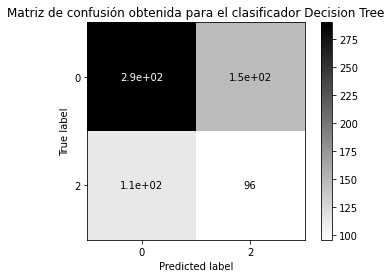

              precision    recall  f1-score   support

           0       0.72      0.66      0.69       438
           2       0.39      0.46      0.42       210

    accuracy                           0.60       648
   macro avg       0.56      0.56      0.56       648
weighted avg       0.61      0.60      0.60       648

La medida F1 para el clasificador DecisionTreeClassifier es 0.4229


In [ ]:
metrics.plot_confusion_matrix(dt, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Decision Tree")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(dt.__class__.__name__,f1))

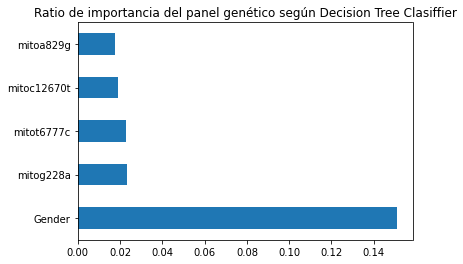

In [ ]:
#En primer lugar, se capturan los valores del ranking de importancia
importancia = dt.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x_train.columns).nlargest(5).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Decision Tree Clasiffier")
plt.show()

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

clf = svm.SVC(class_weight='balanced')
clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)
acc = accuracy_score(y_test,y_pred)
print("El porcentaje de acierto obtenido es",acc*100)

El porcentaje de acierto obtenido es 45.370370370370374


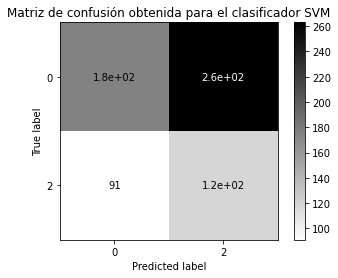

              precision    recall  f1-score   support

           0       0.66      0.40      0.50       438
           2       0.31      0.57      0.40       210

    accuracy                           0.45       648
   macro avg       0.48      0.48      0.45       648
weighted avg       0.55      0.45      0.47       648

La medida F1 para el clasificador SVC es 0.4972


In [ ]:
metrics.plot_confusion_matrix(clf, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador SVM")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=0)
print("La medida F1 para el clasificador %s es %.4f"%(clf.__class__.__name__,f1))


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
GBoost = GradientBoostingClassifier(n_estimators=200, learning_rate=0.9,
                                 max_depth=2, random_state=0).fit(x_train, y_train)
GBoost.score(x_test, y_test)

0.6527777777777778

El porcentaje de acierto obtenido es 65.27777777777779


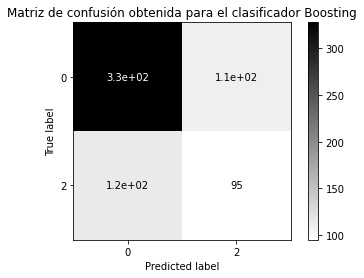

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       438
           2       0.46      0.45      0.46       210

    accuracy                           0.65       648
   macro avg       0.60      0.60      0.60       648
weighted avg       0.65      0.65      0.65       648

La medida F1 para el clasificador GradientBoostingClassifier es 0.4578


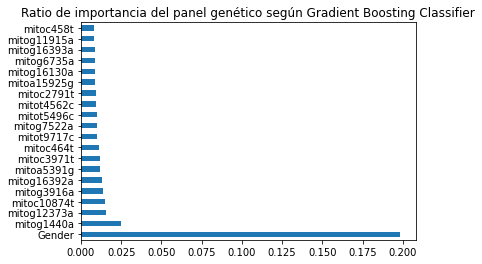

In [ ]:
y_pred = GBoost.predict(x_test)
acc = accuracy_score(y_test,y_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(GBoost, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Boosting")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(GBoost.__class__.__name__,f1))

#En primer lugar, se capturan los valores del ranking de importancia
importancia = GBoost.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x_train.columns).nlargest(20).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Gradient Boosting Classifier")
plt.show()

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
preproc=[("var", VarianceThreshold(0.01)),
        ("standardize", StandardScaler()),
        ("poly", PolynomialFeatures(2))]

pipe=Pipeline([('lr', LogisticRegression())])


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

params_grid=[
          {"lr":[LogisticRegression(penalty='l1',max_iter=500)],
                "lr__C":np.logspace(-2,2,5),
                "lr__solver":['lbfgs']},
          {"lr": [RandomForestClassifier(random_state = 1, n_jobs = -1, criterion = 'entropy')],
          "lr__n_estimators": [100, 250],
          "lr__max_depth": [9, 10]},
          {"lr": [SVC(class_weight='balanced', gamma='scale', degree=2)],
               "lr__C":np.logspace(-2,2,5),
               "lr__kernel": ['rbf', 'poly']}
            
]
best_lr=GridSearchCV(pipe,params_grid, scoring='accuracy', cv=5, n_jobs=-1)
best_lr.fit(x_train,y_train)
print("Parámetros del mejor clasificador:\n{}".format(best_lr.best_params_))
print("Accuracy en CV: {:0.3f}%".format(100.0 * best_lr.best_score_))
print("Accuracy en training: {:0.3f}%".format(
        100.0 * best_lr.score(x_train, y_train)))
print("Accuracy en test: {:0.3f}%".format(
        100.0 * best_lr.score(x_test, y_test)))


Parámetros del mejor clasificador:
{'lr': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False), 'lr__max_depth': 9, 'lr__n_estimators': 250}
Accuracy en CV: 66.719%
Accuracy en training: 87.757%
Accuracy en test: 66.821%


El porcentaje de acierto obtenido es 66.82098765432099


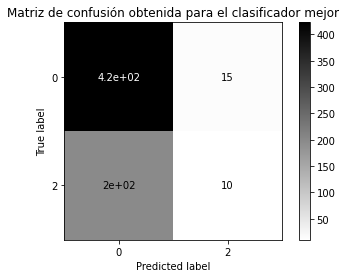

              precision    recall  f1-score   support

           0       0.68      0.97      0.80       438
           2       0.40      0.05      0.09       210

    accuracy                           0.67       648
   macro avg       0.54      0.51      0.44       648
weighted avg       0.59      0.67      0.57       648

La medida F1 para el clasificador GridSearchCV es 0.0851


In [ ]:
y_pred = best_lr.predict(x_test)
acc = accuracy_score(y_test,y_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(best_lr, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador mejor")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(best_lr.__class__.__name__,f1))

# Primeros datos de control

In [ ]:
"""
Lee las bases de datos y comprueba si hay datos perdidos:
    - path_data: indica la ruta del archivo con la base de datos
    - path_names: indica la ruta del archivo con los nombres de las columnas (SNPs)
    - path_control: ruta con los datos de control (individuos sanos)
    - path_col_control: ruta con los nombres de los SNPs de los datos de control
"""
import pandas as pd
import numpy as np
import collections as col
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import random

def readData(path_data, path_names, path_control, path_col_control):
  """ Leemos los datos
  --------------------------------------------------------------------------"""
  data = pd.read_csv(path_data, sep=" ", header=None)
  names_col = pd.read_csv(path_names, sep=",", header=None)
  control = pd.read_csv(path_control, sep=" ", header=None)
  names_ctrl = pd.read_csv(path_col_control, sep=",", header=None)

  """ Primero leo los nombres de los datos de las columnas de datos
  --------------------------------------------------------------------------"""
  # Tomamos los nombres de los snpis para nombrar las columnas
  names_c = names_col.to_numpy()[:,:].astype('U13')
  # En la columna 0 estan los nombres de los SNIPS
  names_column = names_c[:,0]

  """ Ahora buscamos las columnas en común entre los datos y los de control
  --------------------------------------------------------------------------"""
  names_ctrl_aux = names_ctrl.to_numpy()[:,:].astype('U13')
  names_control = names_ctrl_aux[:,0]
  delete = []
  for value in names_column:
    pos = np.where(names_control == value)
    if pos[0].size==0:
      delete.append(value)
  #Encontramos las dos posiciones a borrar que serán 4 en la base de datos
  borrar1 = np.where(names_column == delete[0])
  borrar2 = np.where(names_column == delete[1])
  names_column=np.delete(names_column, [borrar1[0][0],borrar2[0][0]])
  #Borramos las 4 posiciones desde la mas alta para que no afecte a las posiciones
  #más bajas a borrar
  #Se borra la posicion de la bd por 2 porque se repiten los SNPs, mas 7 por las 7
  #columnas iniciales y más 1 o 0 para borrar la pareja
  data.drop(data.columns[borrar2[0][0]*2+7+1], axis=1, inplace=True)
  data.drop(data.columns[borrar2[0][0]*2+7], axis=1, inplace=True)
  data.drop(data.columns[borrar1[0][0]*2+7+1], axis=1, inplace=True)
  data.drop(data.columns[borrar1[0][0]*2+7], axis=1, inplace=True)
  print("Posiciones borradas: ", delete)
  #Renombro las columnas para que el concat se haga bien
  data.columns=list(control.columns.values)
  """ Tratamos los nombres de los datos de las columnas con el formato correcto
  --------------------------------------------------------------------------"""
  names_column = np.repeat(names_column,2)
  names_column = np.insert(names_column, 0, "Gender", axis=0)

  """ Trato ahora con data
  --------------------------------------------------------------------------"""
  # Elimino los hijos de data
  row_elim=[]
  for i in range(0, data.shape[0]):
    if(data[2][i] != '0'):
      row_elim.append(i)
    else:
      data[5][i]='2'
  data=data.drop(row_elim)

  """ Junto con los datos de control
  --------------------------------------------------------------------------"""
  frames = [data,control]
  result = pd.concat(frames)
  """ Borro columnas de los datos
  --------------------------------------------------------------------------"""
  # Predecimos el affection status
  y = result.iloc[:,5]
  # Borramos la columna que queremos predecir
  result.drop(result.columns[5], axis=1, inplace=True)
  # Como nombre de las columnas vamos a establecer el ID del inivididuo
  names_row = result.iloc[:,1]
  # Borramos los ID
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[1], axis=1, inplace=True)

  """ Establezco los nombres del dataframe
  --------------------------------------------------------------------------"""
  x_df = pd.DataFrame(result.to_numpy()[:,:].astype('U13'),index=names_row, columns = names_column)
  y_df = y.values.flatten()

  """ Comprobamos que no haya datos perdidos
  --------------------------------------------------------------------------"""
  if x_df.isnull().values.any():
    print("Hay datos perdidos")
  else:
    print("No hay datos perdidos")

  return x_df, y_df

def explorarBDControl1(x_train, x_test, x, y, y_train, y_test):
  print("Número de instancias y número de variables:", x.shape)
  print("Valores de clase:",pd.unique(y))
  print("Número de instancias para cada clase: ",col.Counter(y))
  print("Número de instancias para cada clase test: ",col.Counter(y_test))
  print("Número de instancias para cada clase train: ",col.Counter(y_train))
  print("Numero de instancias en entrenamiento: {}; y test: {}".format(len(x_train),len(x_test)))
  print()
  
  lista = col.Counter(y)
  valores = [ "Padres de afectados","No afectados"]
  plt.bar(valores, lista.values())
  plt.title("Número de casos en la base de datos. Primer control.")
  plt.show()
  
  print()
  r = list(range(len(x)))
  random.shuffle(r)

  fig = plt.figure()
  ax1 = fig.add_subplot(111)
  for i in r:
    if y[i] == 2:
      ax1.scatter(int(x.iloc[i]['mitoa3721g'][0]), int(x.iloc[i]['mitoa3721g'][1]), s=10, c='b', marker="s", label='Padres')
    else:
      ax1.scatter(int(x.iloc[i]['mitoa3721g'][0]), int(x.iloc[i]['mitoa3721g'][1]), s=10, c='r', marker="o", label='Control')
  
  hand, labl = ax1.get_legend_handles_labels()
  handout=[]
  lablout=[]
  for h,l in zip(hand,labl):
      if l not in lablout:
          lablout.append(l)
          handout.append(h)
  fig.legend(handout, lablout)
  plt.title("Valores en mitoa3721g")
  plt.show()

  print()

  fig2 = plt.figure()
  ax2 = fig2.add_subplot(111)
  for i in r:
    if y[i] == 2:
      ax2.scatter(int(x.iloc[i]['mitoc6046t'][0]), int(x.iloc[i]['mitoc6046t'][1]), s=10, c='b', marker="s", label='Padres')
    else:
      ax2.scatter(int(x.iloc[i]['mitoc6046t'][0]), int(x.iloc[i]['mitoc6046t'][1]), s=10, c='r', marker="o", label='Control')
  
  hand, labl = ax2.get_legend_handles_labels()
  handout=[]
  lablout=[]
  for h,l in zip(hand,labl):
      if l not in lablout:
          lablout.append(l)
          handout.append(h)
  fig2.legend(handout, lablout)
  plt.title("Valores en mitoc6046t")
  plt.show()

  print()


Posiciones borradas:  ['mitoc10874t', 'mitog10590a']
No hay datos perdidos
Número de instancias y número de variables: (4427, 273)
Valores de clase: [2 0]
Número de instancias para cada clase:  Counter({0: 2699, 2: 1728})
Número de instancias para cada clase test:  Counter({0: 659, 2: 448})
Número de instancias para cada clase train:  Counter({0: 2040, 2: 1280})
Numero de instancias en entrenamiento: 3320; y test: 1107



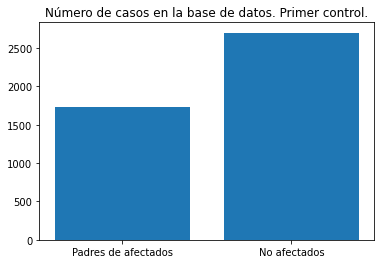

KeyboardInterrupt: ignored

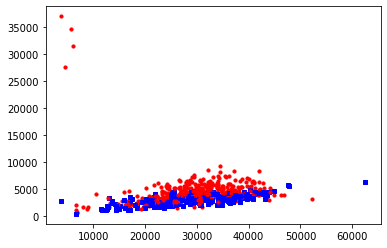

In [ ]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
x, y= readData('/content/drive/MyDrive/TFG/Autism/AutismDuoChrom26.iou','/content/drive/MyDrive/TFG/Autism/Human1M-Duov3_B_PosSortedChrom26.cols','/content/drive/MyDrive/TFG/NBS/WTCCC2_NBSChrom26.iou',
               '/content/drive/MyDrive/TFG/MS/WTCCC2_MS_Human670-QuadCustom_v1_APosSortedChrom26.cols')
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.25, random_state=42)
explorarBDControl1(x_train, x_test, x, y , y_train, y_test)
x[4417:]

### K Vecinos Más Cercanos


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier() 
knn.fit(x_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y_pred = knn.predict(x_test) # predicción de cada etiqueta 

# imprimimos la etiqueta calculada para los 20 primeros datos de X_test
print(y_pred[:20]) 
print(y_test[:20])

[2 2 0 0 2 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0]
[2 2 0 0 2 2 0 0 2 2 0 0 0 2 0 2 0 0 0 0]


In [ ]:
from sklearn.metrics import accuracy_score

acc_score = accuracy_score(y_test, y_pred)
print(acc_score)

0.8003613369467028


In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, x, y) #por defecto 5 particiones

print(scores) #los valores individuales de cada partición
print(np.mean(scores)) #la media de acierto global

[0.78103837 0.79458239 0.81355932 0.76384181 0.7740113 ]
0.7854066393745776


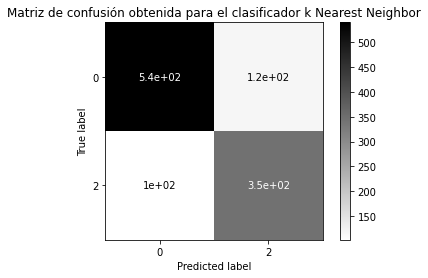

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       659
           2       0.74      0.77      0.76       448

    accuracy                           0.80      1107
   macro avg       0.79      0.80      0.79      1107
weighted avg       0.80      0.80      0.80      1107

La medida F1 para el clasificador KNeighborsClassifier es 0.7579


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

#el parámetro cmap utilizar un mapa de color en azules para ser cómodo a la vista
metrics.plot_confusion_matrix(knn, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador k Nearest Neighbor")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(knn.__class__.__name__,f1))

### Regresión Logística

Coef. independiente: [2.38021692e-07]
Coef. por variable: [[ 3.77381855e-07  1.84598733e-04  6.01776513e-05 -2.61917228e-04
  -6.39011418e-05 -2.72305412e-05 -1.62573963e-04  9.91114189e-05
   2.03877460e-05  6.08417272e-05  3.04678054e-05 -3.22764112e-06
   1.27102939e-05 -2.57709055e-04 -2.66028031e-04 -5.24172261e-06
  -1.88697629e-04  2.02449493e-04 -3.06215487e-05  3.98463125e-04
  -9.00090426e-05  2.23586024e-04  2.88718846e-04  1.58822142e-05
   6.01773198e-05  7.32742134e-05  3.41998627e-05 -2.37922320e-04
  -3.20918707e-04 -1.33559681e-04 -1.62615039e-04  1.11591422e-04
  -1.12706481e-04 -4.37185869e-05 -6.49170866e-05  6.36398549e-05
  -1.22806582e-05  1.26767627e-04  3.18743067e-05  3.89324048e-05
  -2.68574854e-04  4.62953468e-05 -1.40404217e-04  2.17398080e-05
   1.43928835e-04  1.41417075e-05  1.64205766e-04 -1.69037519e-04
  -9.33022331e-05  2.12302101e-05  5.37790656e-05 -3.03360265e-04
  -1.36699375e-04 -7.37002190e-05 -8.92001507e-06  2.60578689e-05
   1.90596528e-04 

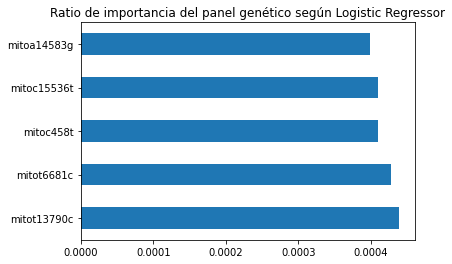


Valores de predicción originales (10 primeros):
[2 0 0 0 2 2 0 0 0 2]

Acierto de Logistic Regression en la partición de test: 0.924119241192412


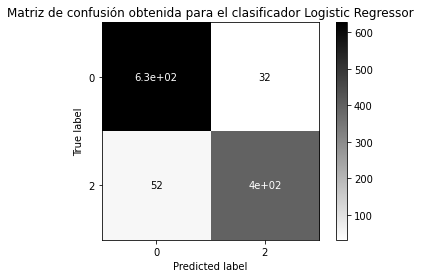

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       659
           2       0.93      0.88      0.90       448

    accuracy                           0.92      1107
   macro avg       0.92      0.92      0.92      1107
weighted avg       0.92      0.92      0.92      1107

La medida F1 para el clasificador LogisticRegression es 0.9041


In [ ]:
from sklearn import linear_model
from sklearn.preprocessing import normalize
lrm = linear_model.LogisticRegression()

lrm.fit(x_train, y_train)
print("Coef. independiente:",lrm.intercept_)
print("Coef. por variable:",lrm.coef_)
print()

importancia = np.abs(lrm.coef_[0]) #transformamos a una lista uni-dimensional
importancia_norm = normalize(importancia[:,np.newaxis], axis=0).ravel()
#Se representan las 5 más importantes según valor absoluto
(pd.Series(importancia, index=x_train.columns).nlargest(5).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Logistic Regressor")
plt.show()
print()

y_pred = lrm.predict(x_test)

print("Valores de predicción originales (10 primeros):")
print(y_pred[:10])
print()

acc_score = accuracy_score(y_test, y_pred)
print("Acierto de Logistic Regression en la partición de test:", acc_score)

metrics.plot_confusion_matrix(lrm, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Logistic Regressor")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(lrm.__class__.__name__,f1))

### Árbol de decisión

In [ ]:
from sklearn import tree

dt = tree.DecisionTreeClassifier()
dt.fit(x_train, y_train)

y_pred = dt.predict(x_test)

acc_score = accuracy_score(y_test, y_pred)
print("Acierto de DT en la partición de test:", acc_score)

Acierto de DT en la partición de test: 0.8726287262872628


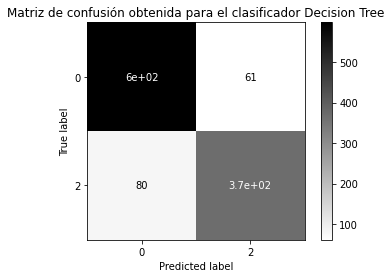

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       659
           2       0.86      0.82      0.84       448

    accuracy                           0.87      1107
   macro avg       0.87      0.86      0.87      1107
weighted avg       0.87      0.87      0.87      1107

La medida F1 para el clasificador DecisionTreeClassifier es 0.8392


In [ ]:
metrics.plot_confusion_matrix(dt, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Decision Tree")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(dt.__class__.__name__,f1))

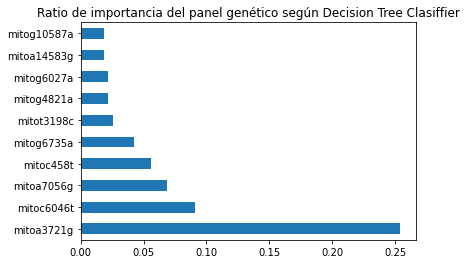

In [ ]:
#En primer lugar, se capturan los valores del ranking de importancia
importancia = dt.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x_train.columns).nlargest(10).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Decision Tree Clasiffier")
plt.show()

### Máquinas de soporte vectorial

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

clf = svm.SVC(C=100.0, break_ties=False, cache_size=200,
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)
acc = accuracy_score(y_test,y_pred)
print("Acierto SVM ",acc)

Acierto SVM  0.9584462511291779


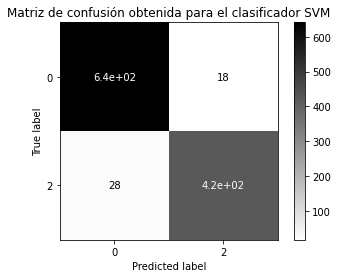

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       659
           2       0.96      0.94      0.95       448

    accuracy                           0.96      1107
   macro avg       0.96      0.96      0.96      1107
weighted avg       0.96      0.96      0.96      1107

La medida F1 para el clasificador SVC es 0.9654


In [ ]:
metrics.plot_confusion_matrix(clf, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador SVM")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=0)
print("La medida F1 para el clasificador %s es %.4f"%(clf.__class__.__name__,f1))

### *Gradient Boosting*

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
GBoost = GradientBoostingClassifier(n_estimators=200, learning_rate=0.9,
                                 max_depth=2, random_state=0).fit(x_train, y_train)
GBoost.score(x_test, y_test)

0.9611562782294489

El porcentaje de acierto obtenido es 96.11562782294489


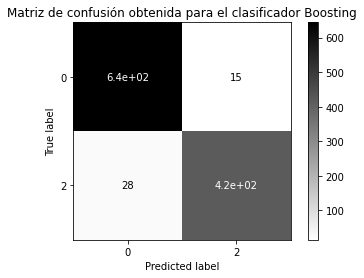

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       659
           2       0.97      0.94      0.95       448

    accuracy                           0.96      1107
   macro avg       0.96      0.96      0.96      1107
weighted avg       0.96      0.96      0.96      1107

La medida F1 para el clasificador GradientBoostingClassifier es 0.9513


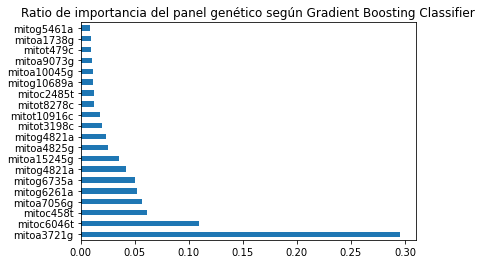

In [ ]:
y_pred = GBoost.predict(x_test)
acc = accuracy_score(y_test,y_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(GBoost, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Boosting")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(GBoost.__class__.__name__,f1))

#En primer lugar, se capturan los valores del ranking de importancia
importancia = GBoost.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x_train.columns).nlargest(20).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Gradient Boosting Classifier")
plt.show()

### *GridSearch CV*

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
preproc=[("var", VarianceThreshold(0.01)),
        ("standardize", StandardScaler()),
        ("poly", PolynomialFeatures(2))]

pipe=Pipeline([('lr', LogisticRegression())])

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

params_grid=[
          {"lr":[LogisticRegression(penalty='l1',max_iter=500)],
                "lr__C":np.logspace(-2,2,5),
                "lr__solver":['lbfgs']},
          {"lr": [RandomForestClassifier(random_state = 1, n_jobs = -1, criterion = 'entropy')],
          "lr__n_estimators": [100, 250],
          "lr__max_depth": [9, 10]},
          {"lr": [SVC(class_weight='balanced', gamma='scale', degree=2)],
               "lr__C":np.logspace(-2,2,5),
               "lr__kernel": ['rbf', 'poly']}
            
]
best_lr=GridSearchCV(pipe,params_grid, scoring='accuracy', cv=5, n_jobs=-1)
best_lr.fit(x_train,y_train)
print("Parámetros del mejor clasificador:\n{}".format(best_lr.best_params_))
print("Accuracy en CV: {:0.3f}%".format(100.0 * best_lr.best_score_))
print("Accuracy en training: {:0.3f}%".format(
        100.0 * best_lr.score(x_train, y_train)))
print("Accuracy en test: {:0.3f}%".format(
        100.0 * best_lr.score(x_test, y_test)))

Parámetros del mejor clasificador:
{'lr': SVC(C=100.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False), 'lr__C': 100.0, 'lr__kernel': 'rbf'}
Accuracy en CV: 95.211%
Accuracy en training: 99.578%
Accuracy en test: 95.754%


El porcentaje de acierto obtenido es 95.7542908762421


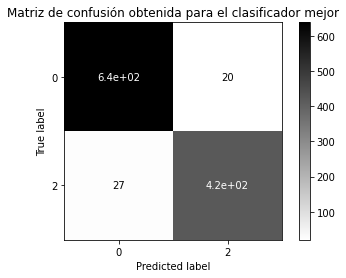

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       659
           2       0.95      0.94      0.95       448

    accuracy                           0.96      1107
   macro avg       0.96      0.95      0.96      1107
weighted avg       0.96      0.96      0.96      1107

La medida F1 para el clasificador GridSearchCV es 0.9471


In [ ]:
y_pred = best_lr.predict(x_test)
acc = accuracy_score(y_test,y_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(best_lr, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador mejor")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(best_lr.__class__.__name__,f1))

# Segundos datos de control

In [ ]:
def explorarBDControl2(x_train, x_test, x, y, y_train, y_test):
  print("Número de instancias y número de variables:", x.shape)
  print("Valores de clase:",pd.unique(y))
  print("Número de instancias para cada clase: ",col.Counter(y))
  print("Número de instancias para cada clase test: ",col.Counter(y_test))
  print("Número de instancias para cada clase train: ",col.Counter(y_train))
  print("Numero de instancias en entrenamiento: {}; y test: {}".format(len(x_train),len(x_test)))
  print()
  
  lista = col.Counter(y)
  valores = [ "Padres de afectados","No afectados"]
  plt.bar(valores, lista.values())
  plt.title("Número de casos en la base de datos. Segundo control.")
  plt.show()

  print()

  r = list(range(len(x)))
  random.shuffle(r)

  fig = plt.figure()
  ax1 = fig.add_subplot(111)
  for i in r:
    if y[i] == 2:
      ax1.scatter(int(x.iloc[i]['mitot3198c'][0]), int(x.iloc[i]['mitot3198c'][1]), s=10, c='b', marker="s", label='Padres')
    else:
      ax1.scatter(int(x.iloc[i]['mitot3198c'][0]), int(x.iloc[i]['mitot3198c'][1]), s=10, c='r', marker="o", label='Control')
  
  hand, labl = ax1.get_legend_handles_labels()
  handout=[]
  lablout=[]
  for h,l in zip(hand,labl):
      if l not in lablout:
          lablout.append(l)
          handout.append(h)
  fig.legend(handout, lablout)
  plt.title("Valores en mitot3198c")
  plt.show()

  print()

  fig2 = plt.figure()
  ax2 = fig2.add_subplot(111)
  for i in r:
    if y[i] == 2:
      ax2.scatter(int(x.iloc[i]['mitot6222c'][0]), int(x.iloc[i]['mitot6222c'][1]), s=10, c='b', marker="s", label='Padres')
    else:
      ax2.scatter(int(x.iloc[i]['mitot6222c'][0]), int(x.iloc[i]['mitot6222c'][1]), s=10, c='r', marker="o", label='Control')
  
  hand, labl = ax2.get_legend_handles_labels()
  handout=[]
  lablout=[]
  for h,l in zip(hand,labl):
      if l not in lablout:
          lablout.append(l)
          handout.append(h)
  fig2.legend(handout, lablout)
  plt.title("Valores en mitot6222c")
  plt.show()

  print()


In [ ]:
"""Se hace ahora de nuevo el estudio con otros datos de control para comprobar
si las diferencias han sido debidas a fallos o métodos distintos de tomar las muestras
en laboratorio o son diferencias reales."""

warnings.filterwarnings("ignore")
x2, y2= readData('/content/drive/MyDrive/TFG/Autism/AutismDuoChrom26.iou','/content/drive/MyDrive/TFG/Autism/Human1M-Duov3_B_PosSortedChrom26.cols','/content/drive/MyDrive/TFG/BC/WTCCC2_BCChrom26.iou',
               '/content/drive/MyDrive/TFG/BC/Human1-2M-DuoCustom_v1_APosSortedChrom26.cols')
x2_train, x2_test, y2_train, y2_test = train_test_split( x2, y2, test_size=0.25, random_state=42)
explorarBDControl2(x2_train, x2_test, x2, y2 , y2_train, y2_test)
x2[4417:]

Accuracy en test coon los nuevos datos de control: 95.783%
El porcentaje de acierto obtenido es 95.78313253012048


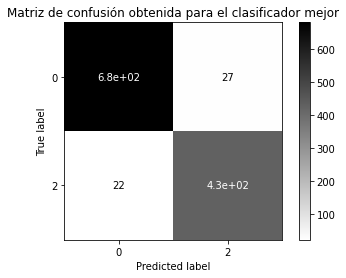

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       709
           2       0.94      0.95      0.95       453

    accuracy                           0.96      1162
   macro avg       0.95      0.96      0.96      1162
weighted avg       0.96      0.96      0.96      1162

La medida F1 para el clasificador GridSearchCV es 0.9462


In [ ]:
print("Accuracy en test coon los nuevos datos de control: {:0.3f}%".format(
        100.0 * best_lr.score(x2_test, y2_test)))
y2_pred = best_lr.predict(x2_test)
acc = accuracy_score(y2_test,y2_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(best_lr, x2_test, y2_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador mejor")
plt.show()

print(metrics.classification_report(y2_test,y2_pred))

f1 = metrics.f1_score(y2_test,y2_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(best_lr.__class__.__name__,f1))

### Árboles de decisión

In [ ]:
dt2 = tree.DecisionTreeClassifier()
dt2.fit(x2_train, y2_train)

y2_pred = dt2.predict(x2_test)

acc_score = accuracy_score(y2_test, y2_pred)
print("Acierto de DT en la partición de test:", acc_score)

Acierto de DT en la partición de test: 0.9165232358003442


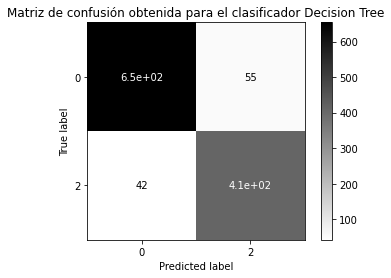

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       709
           2       0.88      0.91      0.89       453

    accuracy                           0.92      1162
   macro avg       0.91      0.91      0.91      1162
weighted avg       0.92      0.92      0.92      1162

La medida F1 para el clasificador DecisionTreeClassifier es 0.8945


In [ ]:
metrics.plot_confusion_matrix(dt2, x2_test, y2_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Decision Tree")
plt.show()

print(metrics.classification_report(y2_test,y2_pred))

f1 = metrics.f1_score(y2_test,y2_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(dt.__class__.__name__,f1))

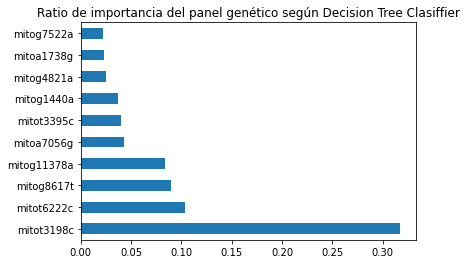

In [ ]:
#En primer lugar, se capturan los valores del ranking de importancia
importancia = dt2.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x_train.columns).nlargest(10).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Decision Tree Clasiffier")
plt.show()

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
GBoost2 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.9,
                                 max_depth=2, random_state=0).fit(x2_train, y2_train)
GBoost2.score(x2_test, y2_test)

0.9810671256454389

El porcentaje de acierto obtenido es 98.10671256454388


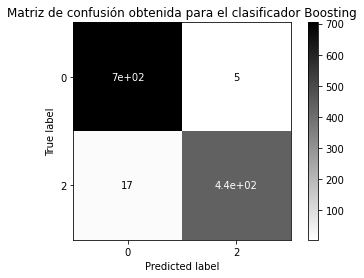

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       709
           2       0.99      0.96      0.98       453

    accuracy                           0.98      1162
   macro avg       0.98      0.98      0.98      1162
weighted avg       0.98      0.98      0.98      1162

La medida F1 para el clasificador GradientBoostingClassifier es 0.9754


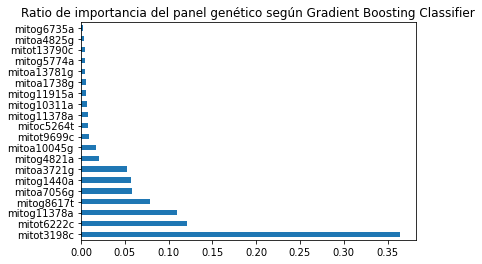

In [ ]:
y2_pred = GBoost2.predict(x2_test)
acc = accuracy_score(y2_test,y2_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(GBoost2, x2_test, y2_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Boosting")
plt.show()

print(metrics.classification_report(y2_test,y2_pred))

f1 = metrics.f1_score(y2_test,y2_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(GBoost2.__class__.__name__,f1))

#En primer lugar, se capturan los valores del ranking de importancia
importancia = GBoost2.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x2_train.columns).nlargest(20).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Gradient Boosting Classifier")
plt.show()

# Diferencias entre ambos controles

In [ ]:
def readControlData(path_control1, path_control2, path_names_col):
  #Transformamos la columna de affection status (que es 0 en ambos dataset) a
  # 0 si es del primer dataset
  # 1 si es del segundo dataset
  #Los nombres de las columnas son los mismos
  data1 = pd.read_csv(path_control1, sep=" ", header=None)
  names_col = pd.read_csv(path_names_col, sep=",", header=None)
  data2 = pd.read_csv(path_control2, sep=" ", header=None)

  names_c = names_col.to_numpy()[:,:].astype('U13')
  # En la columna 0 estan los nombres de los SNPs
  names_column = names_c[:,0]

  #Cambiamos a 1 el affection status del segundo dataset
  for i in range(0, data2.shape[0]):
    data2[5][i]='1'
  
  #Unimos datasets
  frames = [data1,data2]
  result = pd.concat(frames)

  #Repetimos los nombres de las columnas porque cada SNP son 2 columnas
  names_column = np.repeat(names_column,2)
  names_column = np.insert(names_column, 0, "Gender", axis=0)

  # Predecimos el affection status
  y = result.iloc[:,5]
  # Borramos la columna que queremos predecir
  result.drop(result.columns[5], axis=1, inplace=True)
  # Como nombre de las columnas vamos a establecer el ID del inivididuo
  names_row = result.iloc[:,1]
  # Borramos los ID
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[1], axis=1, inplace=True)

  x_df = pd.DataFrame(result.to_numpy()[:,:].astype('U13'),index=names_row, columns = names_column)
  y_df = y.values.flatten()

  if x_df.isnull().values.any():
    print("Hay datos perdidos")
  else:
    print("No hay datos perdidos")

  return x_df, y_df

def explorarBDControles(x_train, x_test, x, y, y_train, y_test):
  print("Número de instancias y número de variables:", x.shape)
  print("Valores de clase:",pd.unique(y))
  print("Número de instancias para cada clase: ",col.Counter(y))
  print("Número de instancias para cada clase test: ",col.Counter(y_test))
  print("Número de instancias para cada clase train: ",col.Counter(y_train))
  print("Numero de instancias en entrenamiento: {}; y test: {}".format(len(x_train),len(x_test)))
  print()

  r = list(range(len(x)))
  random.shuffle(r)

  fig = plt.figure()
  ax1 = fig.add_subplot(111)
  for i in r:
    if y[i] == 1:
      ax1.scatter(int(x.iloc[i]['mitog1440a'][0]), int(x.iloc[i]['mitog1440a'][1]), s=10, c='b', marker="s", label='Control2')
    else:
      ax1.scatter(int(x.iloc[i]['mitog1440a'][0]), int(x.iloc[i]['mitog1440a'][1]), s=10, c='r', marker="o", label='Control1')
  
  hand, labl = ax1.get_legend_handles_labels()
  handout=[]
  lablout=[]
  for h,l in zip(hand,labl):
      if l not in lablout:
          lablout.append(l)
          handout.append(h)
  fig.legend(handout, lablout)
  plt.title("Valores en mitog1440a")
  plt.show()

  print()

  fig2 = plt.figure()
  ax2 = fig2.add_subplot(111)
  for i in r:
    if y[i] == 1:
      ax2.scatter(int(x.iloc[i]['mitoc5264t'][0]), int(x.iloc[i]['mitoc5264t'][1]), s=10, c='b', marker="s", label='Control2')
    else:
      ax2.scatter(int(x.iloc[i]['mitoc5264t'][0]), int(x.iloc[i]['mitoc5264t'][1]), s=10, c='r', marker="o", label='Control1')
  
  hand, labl = ax2.get_legend_handles_labels()
  handout=[]
  lablout=[]
  for h,l in zip(hand,labl):
      if l not in lablout:
          lablout.append(l)
          handout.append(h)
  fig2.legend(handout, lablout)
  plt.title("Valores en mitoc5264t")
  plt.show()

  print()

No hay datos perdidos
Número de instancias y número de variables: (5619, 273)
Valores de clase: [0 1]
Número de instancias para cada clase:  Counter({1: 2920, 0: 2699})
Número de instancias para cada clase test:  Counter({0: 714, 1: 691})
Número de instancias para cada clase train:  Counter({1: 2229, 0: 1985})
Numero de instancias en entrenamiento: 4214; y test: 1405



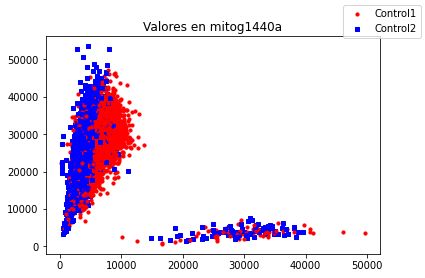

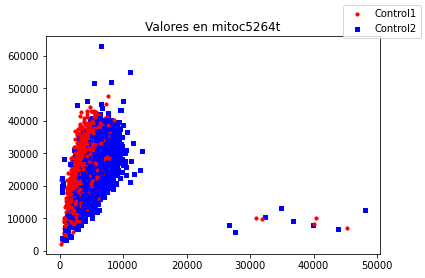

,Gender,mitoa10045g,mitoa10045g,mitoa10551g,mitoa10551g,mitoa11252g,mitoa11252g,mitoa11468g,mitoa11468g,mitoa12309g,mitoa12309g,mitoa13106g,mitoa13106g,mitoa13264g,mitoa13264g,mitoa13781g,mitoa13781g,mitoa14234g,mitoa14234g,mitoa14583g,mitoa14583g,mitoa15245g,mitoa15245g,mitoa15302g,mitoa15302g,mitoa15759g,mitoa15759g,mitoa15925g,mitoa15925g,mitoa16163g,mitoa16163g,mitoa16164g,mitoa16164g,mitoa1738g,mitoa1738g,mitoa3349g,mitoa3349g,mitoa3481g,mitoa3481g,mitoa3721g,...,mitot3198c,mitot3198c,mitot3395c,mitot3395c,mitot4337c,mitot4337c,mitot4562c,mitot4562c,mitot479c,mitot479c,mitot491c,mitot491c,mitot4978c,mitot4978c,mitot5005c,mitot5005c,mitot5443c,mitot5443c,mitot5496c,mitot5496c,mitot6153c,mitot6153c,mitot6222c,mitot6222c,mitot6681c,mitot6681c,mitot6777c,mitot6777c,mitot7176c,mitot7176c,mitot8278c,mitot8278c,mitot9699c,mitot9699c,mitot9717c,mitot9717c,mitot9900c,mitot9900c,mitot9951c,mitot9951c
1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WTCCCT542527,1,16044,1555,19345,4167,18209,3739,22229,4788,17188,3927,7887,1746,20534,4195,9882,2419,11070,1732,9523,1191,11859,3238,10206,25932,22009,4316,15817,3684,17183,5994,16168,2648,11851,2031,20310,5652,14202,3006,21348,...,25273,4486,19825,5415,25571,6520,23519,7488,12825,2862,11779,1505,20171,5940,15468,4300,12076,2726,22426,3974,8907,3459,13960,4873,22914,4198,27963,4468,14420,2750,23574,10909,10745,3956,13514,4792,18948,4250,9611,1345
WTCCCT542637,1,22176,2485,22933,6431,23332,5444,30966,5537,22556,5209,12534,2482,28571,6195,14001,2703,14391,2329,17665,2339,18019,4381,12327,32336,33399,4915,22598,5871,24534,8320,23574,4311,19530,3627,26349,6935,20258,4189,28989,...,34720,5580,25128,6082,33865,8232,32434,9696,17264,3632,14923,1889,27504,7411,23657,5571,16361,3776,33189,6332,14863,5856,20237,6345,31530,5679,35639,4647,21163,3774,30627,13337,15031,5422,20865,6002,21584,5886,13813,2010
WTCCCT543520,2,22427,950,29588,3661,27128,3076,35333,3823,25750,3120,12359,1569,32646,3633,12413,1573,15530,1321,14489,1175,19358,3001,12338,30346,35209,3774,25801,3049,26298,5606,26254,2326,24903,2510,28940,4234,26667,2885,31103,...,38698,3307,32183,4249,39947,5405,36595,7288,17869,2075,13593,935,31459,4765,23389,3197,18146,1870,35705,4091,13710,3204,22898,4375,36796,4774,38389,2525,21655,2149,34636,9579,16909,3504,24035,4686,23597,3135,14299,1087
WTCCCT543533,2,24901,1605,6627,27669,30001,3224,1888,3569,6603,28788,9710,1633,33002,4273,13952,2256,15813,1604,17210,1604,19099,3719,15299,33800,33615,3797,3588,27730,27218,7143,25860,2705,23455,2619,32143,5535,4735,29509,32062,...,39865,3774,28159,4349,37974,6681,37742,8237,27745,3909,18995,1993,32819,5737,24099,4275,17074,2222,39080,4179,12496,3319,22253,5263,36781,4148,42280,3306,23395,2309,36092,10959,2073,19627,22283,4804,26950,3985,13728,1298
WTCCCT542530,1,20058,1787,25564,4606,24809,3763,3156,32166,5692,28760,10401,2087,27563,4640,13204,2519,12239,1889,12173,1601,17979,4026,11511,30639,29187,4126,23778,4665,20798,6716,20412,2856,14673,2006,27137,5806,18875,3450,30297,...,2634,35962,28970,4920,36128,6969,33603,8860,15962,2656,12814,1496,30245,6338,21551,4557,13959,2538,35050,4573,11755,4114,22228,5845,29255,4196,40097,3806,18839,2797,31020,12374,15456,4855,19695,5658,23034,4672,12463,1586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WTCCC66821,2,19934,1193,22818,3008,22412,3049,27070,4014,22188,3891,8253,1242,26233,3439,11636,1738,11575,1128,5355,576,16314,2975,11076,29921,28648,3587,21025,3126,20846,4597,20986,2297,18458,2135,26167,4331,18741,2374,26556,...,31119,3179,25692,3924,32466,5567,25366,6555,14740,1865,10803,1014,25415,4654,19584,3462,12569,1678,30921,3956,10085,3230,17439,3888,31538,4063,32999,3003,17443,2247,27545,10261,136

In [ ]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
x3, y3= readControlData('/content/drive/MyDrive/TFG/NBS/WTCCC2_NBSChrom26.iou','/content/drive/MyDrive/TFG/BC/WTCCC2_BCChrom26.iou',
                      '/content/drive/MyDrive/TFG/MS/WTCCC2_MS_Human670-QuadCustom_v1_APosSortedChrom26.cols')
x3_train, x3_test, y3_train, y3_test = train_test_split( x3, y3, test_size=0.25, random_state=42)
explorarBDControles(x3_train, x3_test, x3, y3 , y3_train, y3_test)
x3[5281:]

## Árboles de decisión

In [ ]:
dt3 = tree.DecisionTreeClassifier()
dt3.fit(x3_train, y3_train)

y3_pred = dt3.predict(x3_test)

acc_score = accuracy_score(y3_test, y3_pred)
print("Acierto de DT en la partición de test:", acc_score)

Acierto de DT en la partición de test: 0.9202846975088967


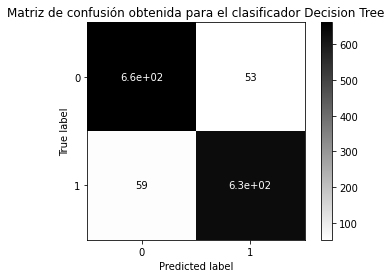

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       714
           1       0.92      0.91      0.92       691

    accuracy                           0.92      1405
   macro avg       0.92      0.92      0.92      1405
weighted avg       0.92      0.92      0.92      1405

La medida F1 para el clasificador DecisionTreeClassifier es 0.9186


In [ ]:
metrics.plot_confusion_matrix(dt3, x3_test, y3_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Decision Tree")
plt.show()

print(metrics.classification_report(y3_test,y3_pred))

f1 = metrics.f1_score(y3_test,y3_pred,pos_label=1)
print("La medida F1 para el clasificador %s es %.4f"%(dt3.__class__.__name__,f1))

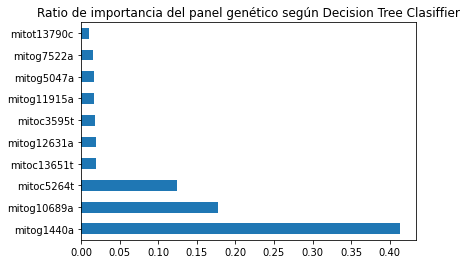

In [ ]:
#En primer lugar, se capturan los valores del ranking de importancia
importancia = dt3.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x_train.columns).nlargest(10).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Decision Tree Clasiffier")
plt.show()

## Support Vector Machine

In [ ]:
clf3 = svm.SVC(C=100.0, break_ties=False, cache_size=200,
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
clf3.fit(x3_train,y3_train)

y3_pred = clf3.predict(x3_test)
acc = accuracy_score(y3_test,y3_pred)
print("Acierto SVM ",acc)

Acierto SVM  0.9551601423487545


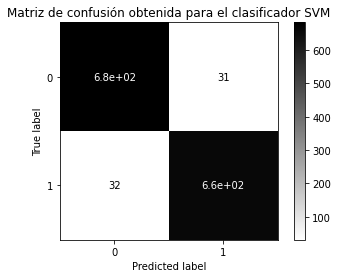

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       714
           1       0.96      0.95      0.95       691

    accuracy                           0.96      1405
   macro avg       0.96      0.96      0.96      1405
weighted avg       0.96      0.96      0.96      1405

La medida F1 para el clasificador SVC es 0.9559


In [ ]:
metrics.plot_confusion_matrix(clf3, x3_test, y3_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador SVM")
plt.show()

print(metrics.classification_report(y3_test,y3_pred))

f1 = metrics.f1_score(y3_test,y3_pred,pos_label=0)
print("La medida F1 para el clasificador %s es %.4f"%(clf3.__class__.__name__,f1))

## Gradient Boosting

In [ ]:
GBoost3 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.9,
                                 max_depth=2, random_state=0).fit(x3_train, y3_train)
GBoost3.score(x3_test, y3_test)

0.9765124555160143

El porcentaje de acierto obtenido es 97.65124555160143


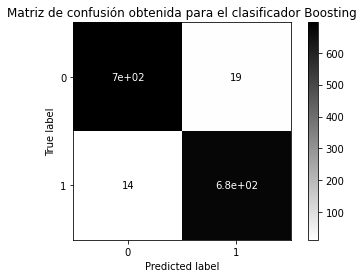

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       714
           1       0.97      0.98      0.98       691

    accuracy                           0.98      1405
   macro avg       0.98      0.98      0.98      1405
weighted avg       0.98      0.98      0.98      1405

La medida F1 para el clasificador GradientBoostingClassifier es 0.9762


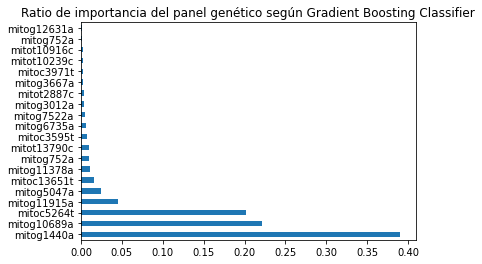

In [ ]:
y3_pred = GBoost3.predict(x3_test)
acc = accuracy_score(y3_test,y3_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(GBoost3, x3_test, y3_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Boosting")
plt.show()

print(metrics.classification_report(y3_test,y3_pred))

f1 = metrics.f1_score(y3_test,y3_pred,pos_label=1)
print("La medida F1 para el clasificador %s es %.4f"%(GBoost3.__class__.__name__,f1))

#En primer lugar, se capturan los valores del ranking de importancia
importancia = GBoost3.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x3_train.columns).nlargest(20).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Gradient Boosting Classifier")
plt.show()

Diferencias claras debido a los sesgos a la hora de obtener el array de muestras.

# Selección de Variables

In [ ]:
"""
Lee las bases de datos y comprueba si hay datos perdidos:
    - path_data: indica la ruta del archivo con la base de datos
    - path_names: indica la ruta del archivo con los nombres de las columnas (SNPs)
    - path_control: ruta con los datos de control (individuos sanos)
    - path_col_control: ruta con los nombres de los SNPs de los datos de control
"""
import pandas as pd
import numpy as np
import collections as col
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

def readDataNoColumnsLabel(path_data, path_names, path_control, path_col_control):
  """ Leemos los datos
  --------------------------------------------------------------------------"""
  data = pd.read_csv(path_data, sep=" ", header=None)
  names_col = pd.read_csv(path_names, sep=",", header=None)
  control = pd.read_csv(path_control, sep=" ", header=None)
  names_ctrl = pd.read_csv(path_col_control, sep=",", header=None)

  """ Primero leo los nombres de los datos de las columnas de datos
  --------------------------------------------------------------------------"""
  # Tomamos los nombres de los snpis para nombrar las columnas
  names_c = names_col.to_numpy()[:,:].astype('U13')
  # En la columna 0 estan los nombres de los SNIPS
  names_column = names_c[:,0]

  """ Ahora buscamos las columnas en común entre los datos y los de control
  --------------------------------------------------------------------------"""
  names_ctrl_aux = names_ctrl.to_numpy()[:,:].astype('U13')
  names_control = names_ctrl_aux[:,0]
  delete = []
  for value in names_column:
    pos = np.where(names_control == value)
    if pos[0].size==0:
      delete.append(value)
  #Encontramos las dos posiciones a borrar que serán 4 en la base de datos
  borrar1 = np.where(names_column == delete[0])
  borrar2 = np.where(names_column == delete[1])
  names_column=np.delete(names_column, [borrar1[0][0],borrar2[0][0]])
  #Borramos las 4 posiciones desde la mas alta para que no afecte a las posiciones
  #más bajas a borrar
  #Se borra la posicion de la bd por 2 porque se repiten los SNPs, mas 7 por las 7
  #columnas iniciales y más 1 o 0 para borrar la pareja
  data.drop(data.columns[borrar2[0][0]*2+7+1], axis=1, inplace=True)
  data.drop(data.columns[borrar2[0][0]*2+7], axis=1, inplace=True)
  data.drop(data.columns[borrar1[0][0]*2+7+1], axis=1, inplace=True)
  data.drop(data.columns[borrar1[0][0]*2+7], axis=1, inplace=True)
  #Renombro las columnas para que el concat se haga bien
  data.columns=list(control.columns.values)
  """ Tratamos los nombres de los datos de las columnas con el formato correcto
  --------------------------------------------------------------------------"""
  names_column = np.repeat(names_column,2)
  names_column = np.insert(names_column, 0, "Gender", axis=0)

  """ Trato ahora con data
  --------------------------------------------------------------------------"""
  # Elimino los hijos de data
  row_elim=[]
  for i in range(0, data.shape[0]):
    if(data[2][i] != '0'):
      row_elim.append(i)
    else:
      data[5][i]='2'
  data=data.drop(row_elim)

  """ Junto con los datos de control
  --------------------------------------------------------------------------"""
  frames = [data,control]
  result = pd.concat(frames)
  """ Borro columnas de los datos
  --------------------------------------------------------------------------"""
  # Predecimos el affection status
  y = result.iloc[:,5]
  # Borramos la columna que queremos predecir
  result.drop(result.columns[5], axis=1, inplace=True)
  # Como nombre de las columnas vamos a establecer el ID del inivididuo
  names_row = result.iloc[:,1]
  # Borramos los ID
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[1], axis=1, inplace=True)

  """ Establezco los nombres del dataframe
  --------------------------------------------------------------------------"""
  x_df = pd.DataFrame(result.to_numpy()[:,:].astype('U13'))
  y_df = y.values.flatten()

  """ Comprobamos que no haya datos perdidos
  --------------------------------------------------------------------------"""
  if x_df.isnull().values.any():
    print("Hay datos perdidos")
  else:
    print("No hay datos perdidos")

  return x_df, y_df, names_column, names_row


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No hay datos perdidos


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


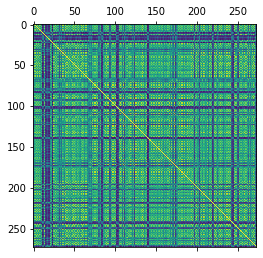

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272
0,1.000000,-0.026484,0.003610,-0.025286,0.004997,-0.023001,-0.004801,-0.013124,-0.014397,-0.017488,-0.008647,0.011499,-0.004082,-0.027534,-0.010987,0.016536,-0.005612,-0.013576,-0.000192,-0.011914,-0.011222,-0.029241,-0.020242,0.002505,-0.000434,-0.027366,-0.012590,-0.025960,-0.021914,-0.041775,-0.009880,-0.037541,-0.023655,-0.023041,-0.013014,-0.031952,-0.007896,-0.032135,0.003576,-0.027346,...,0.004203,-0.020449,-0.026705,-0.018844,-0.013769,0.007546,-0.019774,-0.004889,-0.018203,0.003094,0.005639,0.009158,-0.020377,-0.008569,-0.034836,-0.027818,-0.007399,0.001363,-0.007307,-0.010562,-0.025686,-0.002931,-0.037146,-0.009367,-0.013345,-0.004287,-0.015297,-0.008871,-0.046444,-0.015187,-0.025855,0.010043,-0.021278,-0.014174,-0.034025,-0.020314,-0.030829,-0.011661,-0.023824,0.002988
1,-0.026484,1.000000,-0.167946,0.675728,0.323621,0.650961,0.267312,0.633594,0.283287,0.554373,0.332890,-0.293993,-0.113909,0.692889,0.338232,-0.342353,-0.158040,0.110063,-0.164548,0.028255,-0.169692,0.707467,0.327437,-0.408713,0.345826,0.650757,0.305189,0.729637,0.314978,0.681347,0.313685,0.666319,-0.024801,0.719307,0.074510,0.702167,0.361011,0.701679,0.226339,0.672628,...,0.561498,0.214749,0.663273,0.268747,0.594081,0.314244,0.645394,0.292928,0.149853,-0.080362,-0.198542,-0.131246,0.683654,0.276337,0.775773,0.360433,0.181273,-0.088397,0.634714,0.329256,0.075219,0.333077,0.708242,0.244447,0.656421,0.365142,0.501793,0.288012,0.772373,0.071221,0.687914,0.095114,0.440882,0.307067,0.736385,0.289591,0.771411,0.298148,0.295925,-0.174169
2,0.003610,-0.167946,1.000000,-0.224865,-0.376446,-0.224979,-0.371008,-0.214358,-0.362729,-0.171839,-0.322736,0.126531,0.142209,-0.233820,-0.386907,0.123125,0.301394,0.056224,0.337381,0.115693,0.452901,-0.086130,-0.311650,0.118718,-0.348095,-0.214119,-0.396797,-0.187515,-0.361850,-0.143873,-0.346351,-0.115105,-0.008216,-0.152390,-0.124653,-0.212423,-0.367264,-0.174215,-0.268021,-0.221594,...,-0.205268,-0.317047,-0.216020,-0.408627,-0.227238,-0.352991,-0.208819,-0.399044,0.055024,0.057199,0.141311,0.318999,-0.203843,-0.397456,-0.169955,-0.399927,0.054103,0.056536,-0.219022,-0.376637,0.078948,-0.384991,-0.163645,-0.318144,-0.182307,-0.390053,-0.188994,-0.381108,-0.115323,-0.146460,-0.234517,-0.250903,-0.040407,-0.293193,-0.168353,-0.419798,-0.196118,-0.335469,0.035811,0.444815
3,-0.025286,0.675728,-0.224865,1.000000,0.395599,0.770875,0.323792,0.810907,0.340108,0.735044,0.339403,-0.336630,-0.230904,0.828171,0.395800,-0.274713,-0.275505,-0.039982,-0.257231,-0.106970,-0.230809,0.534018,0.343362,-0.390904,0.488642,0.798615,0.406580,0.726365,0.366262,0.596326,0.427278,0.536396,-0.140357,0.595228,-0.034150,0.833023,0.479983,0.805044,0.146970,0.825938,...,0.701480,0.266594,0.823050,0.398261,0.764423,0.457317,0.800753,0.429764,0.043607,-0.166253,-0.270792,-0.156507,0.830859,0.440529,0.748835,0.409043,0.022643,-0.223657,0.765722,0.358979,-0.064922,0.423754,0.655173,0.391233,0.798415,0.468703,0.644533,0.400045,0.656682,-0.049401,0.789243,0.211614,0.343466,0.267814,0.694197,0.431676,0.793517,0.254599,0.143708,-0.209237
4,0.004997,0.323621,-0.376446,0.395599,1.000000,0.443827,0.655045,0.420472,0.731183,0.242228,0.666925,-0.239760,-0.161856,0.434570,0.733226,-0.214779,-0.254171,-0.102867,-0.294694,-0.166147,-0.336287,0.216665,0.613077,-0.233946,0.679669,0.419354,0.741333,0.346399,0.641236,0.252994,0.648342,0.215143,0.021502,0.256526,0.192423,0.410525,0.770788,0.268974,0.473208,0.447339,...,0.419842,0.595274,0.444930,0.732875,0.418746,0.731249,0.452498,0.704303,-0.082555,-0.091758,-0.212457,-0.301081,0.434766,0.717555,0.351704,0.728066,-0.058908,-0.058780,0.440637,0.711637,-0.139904,0.703364,0.310209,0.494647,0.395135,0.749435,0.356952,0.738267,0.296574,0.203998,0.457932

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

#Releemos los datos
x, y, nc, nr = readDataNoColumnsLabel('/content/drive/MyDrive/TFG/Autism/AutismDuoChrom26.iou','/content/drive/MyDrive/TFG/Autism/Human1M-Duov3_B_PosSortedChrom26.cols','/content/drive/MyDrive/TFG/NBS/WTCCC2_NBSChrom26.iou',
               '/content/drive/MyDrive/TFG/MS/WTCCC2_MS_Human670-QuadCustom_v1_APosSortedChrom26.cols')
y=y.astype('float64')
le = LabelEncoder()
X_encoder=x.copy()

for i in X_encoder.columns:
  X_encoder[i] = le.fit_transform(X_encoder[[i]])
  X_encoder[i] = X_encoder[i].astype('float64')

corr_X = X_encoder.corr(method='pearson')
plt.matshow(corr_X)
plt.show()

X_encoder = pd.DataFrame(X_encoder.to_numpy(), index=X_encoder.index, columns=list(X_encoder.columns.values))

corr_X


Veo algunas correlaciones bastante fuertes.

## Test Chi2

In [ ]:
from sklearn.feature_selection import chi2

chi_scores =chi2(X_encoder, y)

p_values = pd.Series(chi_scores[1],index = nc)
p_values.sort_values(ascending = False , inplace = True)

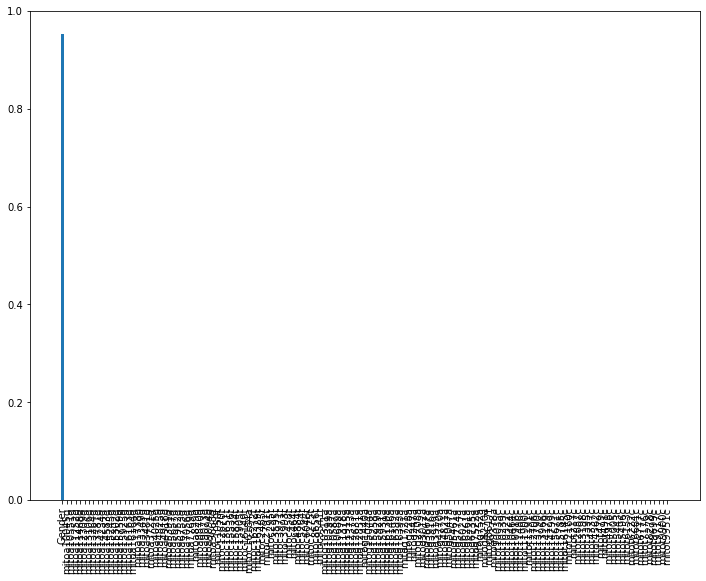

In [ ]:
import matplotlib.pyplot as plt
#Grafica de los p-values
fig = plt.figure(figsize=(12, 9))
langs = nc
plt.bar(langs,p_values)
plt.xticks(rotation=90)
plt.show()

Hipótesis Nula: Son variables independientes.

Si tienen p-value > 0.05 se rechaza la hipótesis nula para esa variable

In [ ]:
THRESHOLD_P_VALUE = 0.05

mayores=0
for i in p_values:
  if i > THRESHOLD_P_VALUE:
    mayores+=1

print("Mayores: ", mayores)
print(X_encoder.shape)

Mayores:  1
(4427, 273)


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

select_k_best_classifier = SelectKBest(chi2, k=272)
X_values=select_k_best_classifier.fit_transform(X_encoder,y)

mask = select_k_best_classifier.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, X_encoder.columns):
    if bool:
        new_features.append(feature)

X_chi = pd.DataFrame(X_values, columns=new_features)

In [ ]:
X_chi

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272
0,1928.0,1721.0,2419.0,873.0,2406.0,967.0,2329.0,656.0,2422.0,1020.0,1482.0,763.0,2684.0,863.0,3541.0,250.0,1870.0,271.0,1880.0,92.0,1879.0,810.0,3520.0,1037.0,2658.0,1139.0,2671.0,1186.0,2788.0,1198.0,3127.0,846.0,2964.0,778.0,2262.0,739.0,2904.0,944.0,2473.0,1470.0,...,2176.0,728.0,2471.0,994.0,2792.0,833.0,2026.0,1100.0,1275.0,492.0,1604.0,234.0,3808.0,350.0,2674.0,1091.0,2161.0,429.0,1649.0,730.0,1336.0,1200.0,2924.0,1629.0,3009.0,1088.0,2797.0,1321.0,2421.0,600.0,3258.0,1752.0,2684.0,1497.0,2823.0,1338.0,2829.0,805.0,1510.0,483.0
1,1922.0,1643.0,1459.0,721.0,1123.0,287.0,1484.0,330.0,1950.0,847.0,386.0,119.0,1419.0,496.0,2626.0,8.0,631.0,1930.0,1051.0,1726.0,1843.0,556.0,3208.0,726.0,1962.0,484.0,1500.0,410.0,1514.0,850.0,1324.0,122.0,990.0,148.0,2110.0,995.0,1714.0,439.0,1770.0,514.0,...,1452.0,332.0,1951.0,502.0,1773.0,999.0,1689.0,543.0,1538.0,230.0,837.0,1844.0,3114.0,220.0,1603.0,403.0,618.0,2044.0,1528.0,366.0,831.0,514.0,1697.0,665.0,2592.0,764.0,2326.0,647.0,1736.0,189.0,2789.0,1243.0,1086.0,982.0,1413.0,608.0,2220.0,487.0,58.0,272.0
2,2744.0,209.0,3162.0,1557.0,3255.0,1046.0,3203.0,1180.0,2908.0,2159.0,1637.0,1262.0,2830.0,789.0,1301.0,1822.0,2713.0,691.0,2512.0,573.0,2939.0,820.0,3530.0,1304.0,3131.0,1564.0,3744.0,1295.0,2442.0,835.0,2778.0,389.0,2525.0,691.0,3306.0,1273.0,3076.0,1690.0,3147.0,968.0,...,2590.0,505.0,3399.0,1202.0,3435.0,1017.0,2422.0,716.0,939.0,426.0,3861.0,1767.0,2967.0,858.0,2484.0,805.0,2340.0,634.0,3107.0,1003.0,2503.0,1146.0,3182.0,1820.0,3651.0,1021.0,3274.0,857.0,3270.0,696.0,1536.0,1183.0,2990.0,1617.0,3320.0,1369.0,2630.0,684.0,3029.0,229.0
3,1548.0,1587.0,2248.0,1051.0,1333.0,1044.0,2021.0,635.0,2361.0,928.0,1317.0,649.0,2873.0,754.0,2945.0,268.0,3112.0,851.0,2307.0,321.0,2454.0,719.0,3201.0,1123.0,2761.0,623.0,2902.0,623.0,2191.0,1045.0,2105.0,308.0,2998.0,688.0,2626.0,1031.0,2966.0,714.0,2316.0,899.0,...,2060.0,304.0,2533.0,713.0,2774.0,679.0,2700.0,1090.0,1833.0,360.0,882.0,1811.0,2518.0,877.0,2111.0,780.0,869.0,79.0,2555.0,849.0,2413.0,1341.0,2184.0,2225.0,3177.0,627.0,2529.0,744.0,2732.0,397.0,1540.0,1053.0,2786.0,1421.0,2694.0,852.0,2609.0,709.0,2487.0,51.0
4,276.0,1163.0,217.0,215.0,553.0,152.0,486.0,103.0,210.0,152.0,2672.0,1657.0,373.0,256.0,1816.0,1361.0,3649.0,1610.0,3745.0,1256.0,276.0,148.0,2108.0,400.0,828.0,271.0,281.0,203.0,180.0,734.0,359.0,2149.0,276.0,115.0,588.0,619.0,366.0,38.0,478.0,346.0,...,4142.0,2664.0,430.0,295.0,533.0,597.0,294.0,349.0,3810.0,1915.0,3017.0,712.0,423.0,339.0,371.0,402.0,3603.0,1875.0,519.0,288.0,3444.0,375.0,293.0,1389.0,791.0,747.0,316.0,289.0,452.0,1936.0,268.0,909.0,17.0,441.0,261.0,204.0,301.0,90.0,3781.0,1028.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4422,3050.0,75.0,2530.0,1034.0,1782.0,600.0,2514.0,935.0,2288.0,1159.0,1411.0,264.0,2801.0,711.0,996.0,468.0,1457.0,1939.0,985.0,1702.0,2295.0,658.0,740.0,1635.0,3611.0,1390.0,1045.0,336.0,1751.0,569.0,3659.0,682.0,2511.0,419.0,2398.0,554.0,1795.0,442.0,1293.0,431.0,...,3511.0,776.0,2120.0,674.0,3469.0,860.0,1941.0,942.0,3133.0,1388.0,1111.0,1699.0,1292.0,491.0,3740.0,1174.0,2639.0,635.0,3754.0,978.0,1206.0,735.0,1923.0,754.0,1416.0,275.0,3765.0,976.0,3005.0,532.0,2874.0,2045.0,1936.0,887.0,3598.0,1682.0,1828.0,616.0,2458.0,1624.0
4423,3867.0,1547.0,859.0,488.0,389.0,455.0,32.0,3051.0,1873.0,1315.0,2772.0,3.0,407.0,607.0,1831.0,1892.0,3340.0,1847.0,2920.0,1689.0,3902.0,151.0,2582.0,3110.0,375.0,979.0,549.0,902.0,397.0,208.0,155.0,33.0,41

## Test de *Variance Threshold*

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_values=selector.fit_transform(X_chi)

mask = selector.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, X_chi.columns):
    if bool:
        new_features.append(feature)

X_var = pd.DataFrame(X_values, columns=new_features)

In [ ]:
X_var

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272
0,1928.0,1721.0,2419.0,873.0,2406.0,967.0,2329.0,656.0,2422.0,1020.0,1482.0,763.0,2684.0,863.0,3541.0,250.0,1870.0,271.0,1880.0,92.0,1879.0,810.0,3520.0,1037.0,2658.0,1139.0,2671.0,1186.0,2788.0,1198.0,3127.0,846.0,2964.0,778.0,2262.0,739.0,2904.0,944.0,2473.0,1470.0,...,2176.0,728.0,2471.0,994.0,2792.0,833.0,2026.0,1100.0,1275.0,492.0,1604.0,234.0,3808.0,350.0,2674.0,1091.0,2161.0,429.0,1649.0,730.0,1336.0,1200.0,2924.0,1629.0,3009.0,1088.0,2797.0,1321.0,2421.0,600.0,3258.0,1752.0,2684.0,1497.0,2823.0,1338.0,2829.0,805.0,1510.0,483.0
1,1922.0,1643.0,1459.0,721.0,1123.0,287.0,1484.0,330.0,1950.0,847.0,386.0,119.0,1419.0,496.0,2626.0,8.0,631.0,1930.0,1051.0,1726.0,1843.0,556.0,3208.0,726.0,1962.0,484.0,1500.0,410.0,1514.0,850.0,1324.0,122.0,990.0,148.0,2110.0,995.0,1714.0,439.0,1770.0,514.0,...,1452.0,332.0,1951.0,502.0,1773.0,999.0,1689.0,543.0,1538.0,230.0,837.0,1844.0,3114.0,220.0,1603.0,403.0,618.0,2044.0,1528.0,366.0,831.0,514.0,1697.0,665.0,2592.0,764.0,2326.0,647.0,1736.0,189.0,2789.0,1243.0,1086.0,982.0,1413.0,608.0,2220.0,487.0,58.0,272.0
2,2744.0,209.0,3162.0,1557.0,3255.0,1046.0,3203.0,1180.0,2908.0,2159.0,1637.0,1262.0,2830.0,789.0,1301.0,1822.0,2713.0,691.0,2512.0,573.0,2939.0,820.0,3530.0,1304.0,3131.0,1564.0,3744.0,1295.0,2442.0,835.0,2778.0,389.0,2525.0,691.0,3306.0,1273.0,3076.0,1690.0,3147.0,968.0,...,2590.0,505.0,3399.0,1202.0,3435.0,1017.0,2422.0,716.0,939.0,426.0,3861.0,1767.0,2967.0,858.0,2484.0,805.0,2340.0,634.0,3107.0,1003.0,2503.0,1146.0,3182.0,1820.0,3651.0,1021.0,3274.0,857.0,3270.0,696.0,1536.0,1183.0,2990.0,1617.0,3320.0,1369.0,2630.0,684.0,3029.0,229.0
3,1548.0,1587.0,2248.0,1051.0,1333.0,1044.0,2021.0,635.0,2361.0,928.0,1317.0,649.0,2873.0,754.0,2945.0,268.0,3112.0,851.0,2307.0,321.0,2454.0,719.0,3201.0,1123.0,2761.0,623.0,2902.0,623.0,2191.0,1045.0,2105.0,308.0,2998.0,688.0,2626.0,1031.0,2966.0,714.0,2316.0,899.0,...,2060.0,304.0,2533.0,713.0,2774.0,679.0,2700.0,1090.0,1833.0,360.0,882.0,1811.0,2518.0,877.0,2111.0,780.0,869.0,79.0,2555.0,849.0,2413.0,1341.0,2184.0,2225.0,3177.0,627.0,2529.0,744.0,2732.0,397.0,1540.0,1053.0,2786.0,1421.0,2694.0,852.0,2609.0,709.0,2487.0,51.0
4,276.0,1163.0,217.0,215.0,553.0,152.0,486.0,103.0,210.0,152.0,2672.0,1657.0,373.0,256.0,1816.0,1361.0,3649.0,1610.0,3745.0,1256.0,276.0,148.0,2108.0,400.0,828.0,271.0,281.0,203.0,180.0,734.0,359.0,2149.0,276.0,115.0,588.0,619.0,366.0,38.0,478.0,346.0,...,4142.0,2664.0,430.0,295.0,533.0,597.0,294.0,349.0,3810.0,1915.0,3017.0,712.0,423.0,339.0,371.0,402.0,3603.0,1875.0,519.0,288.0,3444.0,375.0,293.0,1389.0,791.0,747.0,316.0,289.0,452.0,1936.0,268.0,909.0,17.0,441.0,261.0,204.0,301.0,90.0,3781.0,1028.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4422,3050.0,75.0,2530.0,1034.0,1782.0,600.0,2514.0,935.0,2288.0,1159.0,1411.0,264.0,2801.0,711.0,996.0,468.0,1457.0,1939.0,985.0,1702.0,2295.0,658.0,740.0,1635.0,3611.0,1390.0,1045.0,336.0,1751.0,569.0,3659.0,682.0,2511.0,419.0,2398.0,554.0,1795.0,442.0,1293.0,431.0,...,3511.0,776.0,2120.0,674.0,3469.0,860.0,1941.0,942.0,3133.0,1388.0,1111.0,1699.0,1292.0,491.0,3740.0,1174.0,2639.0,635.0,3754.0,978.0,1206.0,735.0,1923.0,754.0,1416.0,275.0,3765.0,976.0,3005.0,532.0,2874.0,2045.0,1936.0,887.0,3598.0,1682.0,1828.0,616.0,2458.0,1624.0
4423,3867.0,1547.0,859.0,488.0,389.0,455.0,32.0,3051.0,1873.0,1315.0,2772.0,3.0,407.0,607.0,1831.0,1892.0,3340.0,1847.0,2920.0,1689.0,3902.0,151.0,2582.0,3110.0,375.0,979.0,549.0,902.0,397.0,208.0,155.0,33.0,41

## Selección basada en la norma L1

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_var, y)
model = SelectFromModel(lsvc, prefit=True)
X_svc = model.transform(X_var)

mask = model.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, X_var.columns):
    if bool:
        new_features.append(feature)

X_svc = pd.DataFrame(X_svc, columns=new_features)
X_svc

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24,26,27,28,29,30,31,33,34,35,36,37,38,39,40,41,42,43,...,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,251,252,254,255,256,257,258,259,260,261,262,263,264,265,267,268,269,270,271,272
0,1928.0,1721.0,2419.0,873.0,2406.0,967.0,2329.0,656.0,2422.0,1020.0,1482.0,763.0,2684.0,863.0,3541.0,250.0,1870.0,271.0,1880.0,92.0,1879.0,810.0,1037.0,1139.0,2671.0,1186.0,2788.0,1198.0,3127.0,2964.0,778.0,2262.0,739.0,2904.0,944.0,2473.0,1470.0,2603.0,1089.0,389.0,...,1013.0,2439.0,1300.0,2176.0,728.0,2471.0,994.0,2792.0,833.0,2026.0,1100.0,1275.0,492.0,1604.0,234.0,3808.0,350.0,2674.0,1091.0,2161.0,1649.0,730.0,1200.0,2924.0,1629.0,3009.0,1088.0,2797.0,1321.0,2421.0,600.0,3258.0,1752.0,2684.0,2823.0,1338.0,2829.0,805.0,1510.0,483.0
1,1922.0,1643.0,1459.0,721.0,1123.0,287.0,1484.0,330.0,1950.0,847.0,386.0,119.0,1419.0,496.0,2626.0,8.0,631.0,1930.0,1051.0,1726.0,1843.0,556.0,726.0,484.0,1500.0,410.0,1514.0,850.0,1324.0,990.0,148.0,2110.0,995.0,1714.0,439.0,1770.0,514.0,2151.0,762.0,196.0,...,1328.0,1701.0,1168.0,1452.0,332.0,1951.0,502.0,1773.0,999.0,1689.0,543.0,1538.0,230.0,837.0,1844.0,3114.0,220.0,1603.0,403.0,618.0,1528.0,366.0,514.0,1697.0,665.0,2592.0,764.0,2326.0,647.0,1736.0,189.0,2789.0,1243.0,1086.0,1413.0,608.0,2220.0,487.0,58.0,272.0
2,2744.0,209.0,3162.0,1557.0,3255.0,1046.0,3203.0,1180.0,2908.0,2159.0,1637.0,1262.0,2830.0,789.0,1301.0,1822.0,2713.0,691.0,2512.0,573.0,2939.0,820.0,1304.0,1564.0,3744.0,1295.0,2442.0,835.0,2778.0,2525.0,691.0,3306.0,1273.0,3076.0,1690.0,3147.0,968.0,3201.0,1415.0,3086.0,...,1342.0,2285.0,1170.0,2590.0,505.0,3399.0,1202.0,3435.0,1017.0,2422.0,716.0,939.0,426.0,3861.0,1767.0,2967.0,858.0,2484.0,805.0,2340.0,3107.0,1003.0,1146.0,3182.0,1820.0,3651.0,1021.0,3274.0,857.0,3270.0,696.0,1536.0,1183.0,2990.0,3320.0,1369.0,2630.0,684.0,3029.0,229.0
3,1548.0,1587.0,2248.0,1051.0,1333.0,1044.0,2021.0,635.0,2361.0,928.0,1317.0,649.0,2873.0,754.0,2945.0,268.0,3112.0,851.0,2307.0,321.0,2454.0,719.0,1123.0,623.0,2902.0,623.0,2191.0,1045.0,2105.0,2998.0,688.0,2626.0,1031.0,2966.0,714.0,2316.0,899.0,2551.0,887.0,3025.0,...,1215.0,1515.0,1027.0,2060.0,304.0,2533.0,713.0,2774.0,679.0,2700.0,1090.0,1833.0,360.0,882.0,1811.0,2518.0,877.0,2111.0,780.0,869.0,2555.0,849.0,1341.0,2184.0,2225.0,3177.0,627.0,2529.0,744.0,2732.0,397.0,1540.0,1053.0,2786.0,2694.0,852.0,2609.0,709.0,2487.0,51.0
4,276.0,1163.0,217.0,215.0,553.0,152.0,486.0,103.0,210.0,152.0,2672.0,1657.0,373.0,256.0,1816.0,1361.0,3649.0,1610.0,3745.0,1256.0,276.0,148.0,400.0,271.0,281.0,203.0,180.0,734.0,359.0,276.0,115.0,588.0,619.0,366.0,38.0,478.0,346.0,407.0,453.0,163.0,...,947.0,332.0,944.0,4142.0,2664.0,430.0,295.0,533.0,597.0,294.0,349.0,3810.0,1915.0,3017.0,712.0,423.0,339.0,371.0,402.0,3603.0,519.0,288.0,375.0,293.0,1389.0,791.0,747.0,316.0,289.0,452.0,1936.0,268.0,909.0,17.0,261.0,204.0,301.0,90.0,3781.0,1028.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4422,3050.0,75.0,2530.0,1034.0,1782.0,600.0,2514.0,935.0,2288.0,1159.0,1411.0,264.0,2801.0,711.0,996.0,468.0,1457.0,1939.0,985.0,1702.0,2295.0,658.0,1635.0,1390.0,1045.0,336.0,1751.0,569.0,3659.0,2511.0,419.0,2398.0,554.0,1795.0,442.0,1293.0,431.0,3015.0,1214.0,2848.0,...,749.0,2118.0,924.0,3511.0,776.0,2120.0,674.0,3469.0,860.0,1941.0,942.0,3133.0,1388.0,1111.0,1699.0,1292.0,491.0,3740.0,1174.0,2639.0,3754.0,978.0,735.0,1923.0,754.0,1416.0,275.0,3765.0,976.0,3005.0,532.0,2874.0,2045.0,1936.0,3598.0,1682.0,1828.0,616.0,2458.0,1624.0
4423,3867.0,1547.0,859.0,488.0,389.0,455.0,32.0,3051.0,1873.0,1315.0,2772.0,3.0,407.0,607.0,1831.0,1892.0,3340.0,1847.0,2920.0,1689.0,3902.0,151.0,3110.0,979.0,549.0,902.0,397.0,208.0,155.0,415.0,438.0,399.

## Selección basada en Árboles

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf_sel = ExtraTreesClassifier(n_estimators=50)
clf_sel = clf_sel.fit(X_svc, y)
clf_sel.feature_importances_ 

array([0.00377382, 0.00632571, 0.00209261, 0.00200905, 0.00161406,
       0.00302229, 0.00179601, 0.00427513, 0.00169414, 0.00261724,
       0.00270489, 0.00189055, 0.00225009, 0.00240266, 0.00216378,
       0.00665917, 0.00182163, 0.00226303, 0.00401161, 0.00289708,
       0.00347273, 0.00946435, 0.0122598 , 0.00182671, 0.0020057 ,
       0.00413819, 0.00211514, 0.00158164, 0.00250347, 0.00306493,
       0.00264434, 0.0023375 , 0.00197242, 0.00165271, 0.00166625,
       0.0022564 , 0.01212618, 0.00193678, 0.0099175 , 0.00317376,
       0.00261484, 0.00295212, 0.00205067, 0.0025952 , 0.00209537,
       0.00259121, 0.00251545, 0.00209821, 0.00953661, 0.00261443,
       0.00187428, 0.00161448, 0.01104839, 0.00227926, 0.00165865,
       0.00240651, 0.00275516, 0.00200609, 0.00489044, 0.00478605,
       0.00164745, 0.00247219, 0.00490927, 0.00304134, 0.00391499,
       0.00462752, 0.00319891, 0.00505284, 0.00395517, 0.00218679,
       0.00220985, 0.0091637 , 0.00751292, 0.00216885, 0.00337

In [ ]:
model = SelectFromModel(clf_sel, prefit=True)
X_etc = model.transform(X_svc)

mask = model.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, X_var.columns):
    if bool:
        new_features.append(feature)

X_etc = pd.DataFrame(X_etc, columns = new_features)
X_etc

,2,8,16,19,22,23,26,37,39,49,53,59,60,63,65,66,68,69,72,73,76,81,85,88,90,91,92,98,99,101,102,103,104,108,109,110,114,115,116,117,...,127,128,140,141,142,144,147,150,151,153,155,156,159,160,163,164,167,169,170,171,173,175,176,179,180,182,185,187,194,208,212,217,223,225,227,229,231,244,248,254
0,1721.0,656.0,250.0,1880.0,810.0,1037.0,1186.0,1470.0,1089.0,1160.0,1115.0,2821.0,1335.0,957.0,874.0,1038.0,1908.0,891.0,1836.0,876.0,1018.0,1032.0,1087.0,1388.0,916.0,1240.0,1196.0,1078.0,1608.0,798.0,1249.0,881.0,1625.0,542.0,1979.0,1291.0,1303.0,739.0,1735.0,2638.0,...,3053.0,1537.0,1682.0,1966.0,943.0,930.0,1116.0,1167.0,1229.0,2597.0,1860.0,1037.0,1193.0,1088.0,1676.0,3736.0,1418.0,1246.0,1769.0,1469.0,1199.0,1290.0,1019.0,1313.0,125.0,1216.0,1249.0,437.0,1496.0,278.0,1108.0,962.0,728.0,994.0,833.0,1100.0,492.0,3009.0,2421.0,1338.0
1,1643.0,330.0,8.0,1051.0,556.0,726.0,410.0,514.0,762.0,473.0,461.0,2128.0,361.0,1980.0,461.0,1052.0,1135.0,781.0,756.0,510.0,777.0,1018.0,1098.0,938.0,658.0,909.0,961.0,889.0,821.0,597.0,1297.0,73.0,1242.0,519.0,823.0,925.0,701.0,403.0,976.0,2212.0,...,1884.0,716.0,918.0,1471.0,1070.0,1041.0,634.0,716.0,536.0,2142.0,1007.0,815.0,552.0,702.0,1623.0,3641.0,863.0,640.0,640.0,802.0,979.0,764.0,1197.0,580.0,5.0,846.0,707.0,235.0,1078.0,1881.0,549.0,589.0,332.0,502.0,999.0,543.0,230.0,2592.0,1736.0,608.0
2,209.0,1180.0,1822.0,2512.0,820.0,1304.0,1295.0,968.0,1415.0,994.0,1155.0,3515.0,1083.0,719.0,824.0,1894.0,2054.0,1483.0,2377.0,235.0,994.0,1281.0,1802.0,1400.0,740.0,1533.0,1015.0,2152.0,689.0,1095.0,2255.0,390.0,1887.0,1521.0,1413.0,1894.0,2158.0,504.0,1261.0,2887.0,...,3216.0,1352.0,1269.0,2226.0,3375.0,3871.0,531.0,3883.0,839.0,2948.0,1017.0,1865.0,933.0,1165.0,696.0,2056.0,912.0,1321.0,2236.0,1782.0,1638.0,4009.0,2400.0,1518.0,1288.0,834.0,1470.0,1155.0,117.0,159.0,1272.0,965.0,505.0,1202.0,1017.0,716.0,426.0,3651.0,3270.0,1369.0
3,1587.0,635.0,268.0,2307.0,719.0,1123.0,623.0,899.0,887.0,1019.0,658.0,3118.0,783.0,534.0,738.0,1965.0,1093.0,1592.0,1510.0,233.0,1390.0,1145.0,1888.0,1088.0,800.0,1397.0,1071.0,1040.0,727.0,998.0,1549.0,154.0,1467.0,1497.0,1429.0,2016.0,1187.0,296.0,1158.0,2307.0,...,3192.0,1105.0,1417.0,1959.0,1616.0,1183.0,901.0,1826.0,526.0,2509.0,1139.0,1283.0,536.0,979.0,735.0,1694.0,752.0,1431.0,1573.0,1380.0,1244.0,1308.0,2551.0,1071.0,1089.0,842.0,915.0,284.0,2098.0,249.0,770.0,933.0,304.0,713.0,679.0,1090.0,360.0,3177.0,2732.0,852.0
4,1163.0,103.0,1361.0,3745.0,148.0,400.0,203.0,346.0,453.0,194.0,281.0,510.0,202.0,1787.0,1987.0,540.0,316.0,372.0,624.0,68.0,450.0,704.0,447.0,33.0,1929.0,513.0,182.0,583.0,71.0,14.0,581.0,1790.0,346.0,905.0,206.0,593.0,487.0,1710.0,507.0,781.0,...,1214.0,651.0,580.0,2830.0,643.0,906.0,155.0,790.0,293.0,187.0,287.0,517.0,2296.0,447.0,2074.0,651.0,2579.0,574.0,142.0,752.0,462.0,552.0,1702.0,595.0,353.0,101.0,386.0,1705.0,955.0,1505.0,299.0,249.0,2664.0,295.0,597.0,349.0,1915.0,791.0,452.0,204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4422,75.0,935.0,468.0,985.0,658.0,1635.0,336.0,431.0,1214.0,1020.0,1258.0,2825.0,869.0,397.0,477.0,767.0,979.0,958.0,1338.0,1664.0,1128.0,849.0,1832.0,942.0,702.0,1329.0,1003.0,1091.0,1635.0,563.0,863.0,571.0,1221.0,1122.0,627.0,3968.0,1487.0,231.0,841.0,878.0,...,2637.0,1997.0,1153.0,1229.0,1752.0,731.0,1569.0,875.0,443.0,2578.0,2469.0,2402.0,591.0,1052.0,630.0,1164.0,531.0,1103.0,674.0,928.0,910.0,1530.0,1358.0,720.0,1470.0,1821.0,1022.0,292.0,1387.0,271.0,909.0,1765.0,776.0,674.0,860.0,942.0,1388.0,1416.0,3005.0,1682.0
4423,1547.0,3051.0,1892.0,2920.0,151.0,3110.0,902.0,782.0,1151.0,492.0,319.0,161.0,741.0,1881.0,2123.0,1033.0,3106.0,521.0,775.0,474.0,3898.0,1611.0,3010.0,285.0,324.0,3022.0,966.0,3115.0,355.0,522.0,3708.0,2013.0,423.0,609.0,

## Reentrenamiento de modelos con selección de variables

In [ ]:
from sklearn.model_selection import train_test_split
x4_train, x4_test, y4_train, y4_test = train_test_split( X_etc, y, test_size=0.25, random_state=42)

### Árboles de decision

In [ ]:
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

dt = tree.DecisionTreeClassifier()
dt.fit(x4_train, y4_train)

y_pred = dt.predict(x4_test)

acc_score = accuracy_score(y4_test, y_pred)
print("Acierto de DT en la partición de test:", acc_score)

Acierto de DT en la partición de test: 0.8599819331526649


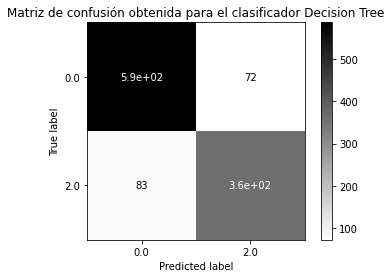

              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88       659
         2.0       0.84      0.81      0.82       448

    accuracy                           0.86      1107
   macro avg       0.86      0.85      0.85      1107
weighted avg       0.86      0.86      0.86      1107

La medida F1 para el clasificador DecisionTreeClassifier es 0.8249


In [ ]:
metrics.plot_confusion_matrix(dt, x4_test, y4_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Decision Tree")
plt.show()

print(metrics.classification_report(y4_test,y_pred))

f1 = metrics.f1_score(y4_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(dt.__class__.__name__,f1))

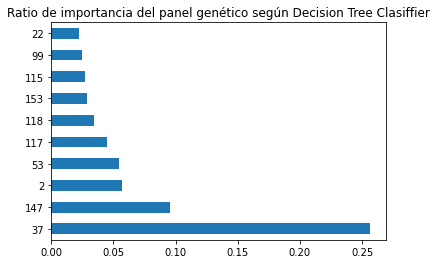

In [ ]:
#En primer lugar, se capturan los valores del ranking de importancia
importancia = dt.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x4_train.columns).nlargest(10).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Decision Tree Clasiffier")
plt.show()

### *Gradient Boosting*

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
GBoost = GradientBoostingClassifier(n_estimators=200, learning_rate=0.9,
                                 max_depth=2, random_state=0).fit(x4_train, y4_train)
GBoost.score(x4_test, y4_test)

0.9539295392953929

El porcentaje de acierto obtenido es 95.39295392953929


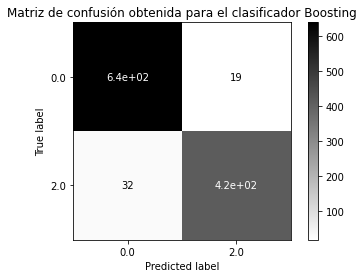

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       659
         2.0       0.96      0.93      0.94       448

    accuracy                           0.95      1107
   macro avg       0.95      0.95      0.95      1107
weighted avg       0.95      0.95      0.95      1107

La medida F1 para el clasificador GradientBoostingClassifier es 0.9422


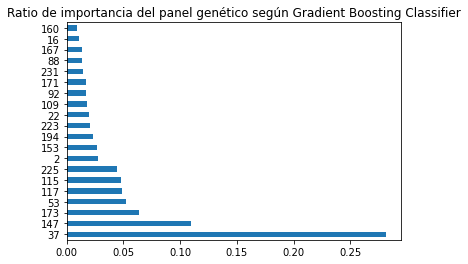

In [ ]:
y_pred = GBoost.predict(x4_test)
acc = accuracy_score(y4_test,y_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(GBoost, x4_test, y4_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Boosting")
plt.show()

print(metrics.classification_report(y4_test,y_pred))

f1 = metrics.f1_score(y4_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(GBoost.__class__.__name__,f1))

#En primer lugar, se capturan los valores del ranking de importancia
importancia = GBoost.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x4_train.columns).nlargest(20).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Gradient Boosting Classifier")
plt.show()

Tanto *Árboles de Decisión* como *Gradient Boosting* lanzan resultados ligeramente peores con la selección de variables.

### *GridSearch CV*

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
preproc=[("var", VarianceThreshold(0.01)),
        ("standardize", StandardScaler()),
        ("poly", PolynomialFeatures(2))]

pipe=Pipeline([('lr', LogisticRegression())])

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

params_grid=[
          {"lr":[LogisticRegression(penalty='l1',max_iter=500)],
                "lr__C":np.logspace(-2,2,5),
                "lr__solver":['lbfgs']},
          {"lr": [RandomForestClassifier(random_state = 1, n_jobs = -1, criterion = 'entropy')],
          "lr__n_estimators": [100, 250],
          "lr__max_depth": [9, 10]},
          {"lr": [SVC(class_weight='balanced', gamma='scale', degree=2)],
               "lr__C":np.logspace(-2,2,5),
               "lr__kernel": ['rbf', 'poly']}
            
]
best_lr=GridSearchCV(pipe,params_grid, scoring='accuracy', cv=5, n_jobs=-1)
best_lr.fit(x4_train,y4_train)
print("Parámetros del mejor clasificador:\n{}".format(best_lr.best_params_))
print("Accuracy en CV: {:0.3f}%".format(100.0 * best_lr.best_score_))
print("Accuracy en training: {:0.3f}%".format(
        100.0 * best_lr.score(x4_train, y4_train)))
print("Accuracy en test: {:0.3f}%".format(
        100.0 * best_lr.score(x4_test, y4_test)))

Parámetros del mejor clasificador:
{'lr': SVC(C=10.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False), 'lr__C': 10.0, 'lr__kernel': 'rbf'}
Accuracy en CV: 96.054%
Accuracy en training: 99.759%
Accuracy en test: 95.664%


Puntuación parecida al conjunto sin selección de variables

El porcentaje de acierto obtenido es 95.6639566395664


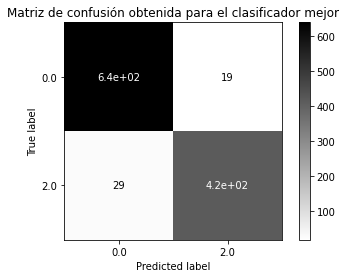

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       659
         2.0       0.96      0.94      0.95       448

    accuracy                           0.96      1107
   macro avg       0.96      0.95      0.95      1107
weighted avg       0.96      0.96      0.96      1107

La medida F1 para el clasificador GridSearchCV es 0.9458


In [ ]:
y_pred = best_lr.predict(x4_test)
acc = accuracy_score(y4_test,y_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(best_lr, x4_test, y4_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador mejor")
plt.show()

print(metrics.classification_report(y4_test,y_pred))

f1 = metrics.f1_score(y4_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(best_lr.__class__.__name__,f1))

### *GridSearch CV* con selección basada en L1

In [ ]:
from sklearn.model_selection import train_test_split
x5_train, x5_test, y5_train, y5_test = train_test_split( X_svc, y, test_size=0.25,random_state=1)

In [ ]:
preproc=[("var", VarianceThreshold(0.01)),
        ("standardize", StandardScaler()),
        ("poly", PolynomialFeatures(2))]

pipe=Pipeline([('lr', LogisticRegression())])

In [ ]:
params_grid=[
          {"lr":[LogisticRegression(penalty='l1',max_iter=500)],
                "lr__C":np.logspace(-2,2,5),
                "lr__solver":['lbfgs']},
          {"lr": [RandomForestClassifier(random_state = 1, n_jobs = -1, criterion = 'entropy')],
          "lr__n_estimators": [100, 250],
          "lr__max_depth": [9, 10]},
          {"lr": [SVC(class_weight='balanced', gamma='scale', degree=2)],
               "lr__C":np.logspace(-3,3,7),
               "lr__kernel": ['rbf', 'poly']}
            
]
best_lr=GridSearchCV(pipe,params_grid, scoring='accuracy', cv=5, n_jobs=-1)
best_lr.fit(x5_train,y5_train)
print("Parámetros del mejor clasificador:\n{}".format(best_lr.best_params_))
print("Accuracy en CV: {:0.3f}%".format(100.0 * best_lr.best_score_))
print("Accuracy en training: {:0.3f}%".format(
        100.0 * best_lr.score(x5_train, y5_train)))
print("Accuracy en test: {:0.3f}%".format(
        100.0 * best_lr.score(x5_test, y5_test)))

Parámetros del mejor clasificador:
{'lr': SVC(C=10.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False), 'lr__C': 10.0, 'lr__kernel': 'rbf'}
Accuracy en CV: 97.560%
Accuracy en training: 100.000%
Accuracy en test: 98.103%


Puntuación perfecta en el conjunto de entrenamiento y alta en el de test.

El porcentaje de acierto obtenido es 98.1029810298103


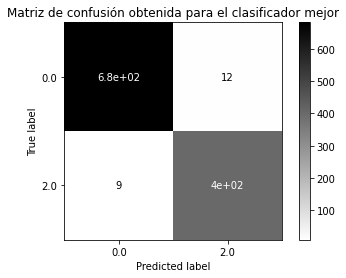

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       694
         2.0       0.97      0.98      0.97       413

    accuracy                           0.98      1107
   macro avg       0.98      0.98      0.98      1107
weighted avg       0.98      0.98      0.98      1107

La medida F1 para el clasificador GridSearchCV es 0.9747


In [ ]:
y_pred = best_lr.predict(x5_test)
acc = accuracy_score(y5_test,y_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(best_lr, x5_test, y5_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador mejor")
plt.show()

print(metrics.classification_report(y5_test,y_pred))

f1 = metrics.f1_score(y5_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(best_lr.__class__.__name__,f1))

El modelo (SVM) con mejores resultados hasta el momento con una selección de variables de chi2 y después otra basada en la norma L1.

# Diferencias de sesgo

Lectura de datos sumando las dos posiciones SNPs

In [2]:
"""
Lee las bases de datos y comprueba si hay datos perdidos:
    - path_data: indica la ruta del archivo con la base de datos
    - path_names: indica la ruta del archivo con los nombres de las columnas (SNPs)
    - path_control: ruta con los datos de control (individuos sanos)
    - path_col_control: ruta con los nombres de los SNPs de los datos de control
"""
import pandas as pd
import numpy as np
import collections as col
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

def readDataSuma(path_data, path_names, path_control, path_col_control):
  """ Leemos los datos
  --------------------------------------------------------------------------"""
  data = pd.read_csv(path_data, sep=" ", header=None)
  names_col = pd.read_csv(path_names, sep=",", header=None)
  control = pd.read_csv(path_control, sep=" ", header=None)
  names_ctrl = pd.read_csv(path_col_control, sep=",", header=None)

  """ Primero leo los nombres de los datos de las columnas de datos
  --------------------------------------------------------------------------"""
  # Tomamos los nombres de los snpis para nombrar las columnas
  names_c = names_col.to_numpy()[:,:].astype('U13')
  # En la columna 0 estan los nombres de los SNIPS
  names_column = names_c[:,0]

  """ Ahora buscamos las columnas en común entre los datos y los de control
  --------------------------------------------------------------------------"""
  names_ctrl_aux = names_ctrl.to_numpy()[:,:].astype('U13')
  names_control = names_ctrl_aux[:,0]
  delete = []
  for value in names_column:
    pos = np.where(names_control == value)
    if pos[0].size==0:
      delete.append(value)
  #Encontramos las dos posiciones a borrar que serán 4 en la base de datos
  borrar1 = np.where(names_column == delete[0])
  borrar2 = np.where(names_column == delete[1])
  names_column=np.delete(names_column, [borrar1[0][0],borrar2[0][0]])
  #Borramos las 4 posiciones desde la mas alta para que no afecte a las posiciones
  #más bajas a borrar
  #Se borra la posicion de la bd por 2 porque se repiten los SNPs, mas 7 por las 7
  #columnas iniciales y más 1 o 0 para borrar la pareja
  data.drop(data.columns[borrar2[0][0]*2+7+1], axis=1, inplace=True)
  data.drop(data.columns[borrar2[0][0]*2+7], axis=1, inplace=True)
  data.drop(data.columns[borrar1[0][0]*2+7+1], axis=1, inplace=True)
  data.drop(data.columns[borrar1[0][0]*2+7], axis=1, inplace=True)
  #Renombro las columnas para que el concat se haga bien
  data.columns=list(control.columns.values)
  """ Tratamos los nombres de los datos de las columnas con el formato correcto
  --------------------------------------------------------------------------"""

  """ Trato ahora con data
  --------------------------------------------------------------------------"""
  # Elimino los hijos de data
  row_elim=[]
  for i in range(0, data.shape[0]):
    if(data[2][i] != '0'):
      row_elim.append(i)
    else:
      data[5][i]='2'
  data=data.drop(row_elim)

  """ Junto con los datos de control
  --------------------------------------------------------------------------"""
  frames = [data,control]
  result = pd.concat(frames)
  """ Borro columnas de los datos
  --------------------------------------------------------------------------"""
  # Predecimos el affection status
  y = result.iloc[:,5]
  # Borramos la columna que queremos predecir
  result.drop(result.columns[5], axis=1, inplace=True)
  # Como nombre de las columnas vamos a establecer el ID del inivididuo
  names_row = result.iloc[:,1]
  # Borramos los ID
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)

  data.drop(data.columns[5], axis=1, inplace=True)
  data.drop(data.columns[0], axis=1, inplace=True)
  data.drop(data.columns[0], axis=1, inplace=True)
  data.drop(data.columns[0], axis=1, inplace=True)
  data.drop(data.columns[0], axis=1, inplace=True)
  data.drop(data.columns[0], axis=1, inplace=True)
  data.drop(data.columns[0], axis=1, inplace=True)

  control.drop(control.columns[5], axis=1, inplace=True)
  control.drop(control.columns[0], axis=1, inplace=True)
  control.drop(control.columns[0], axis=1, inplace=True)
  control.drop(control.columns[0], axis=1, inplace=True)
  control.drop(control.columns[0], axis=1, inplace=True)
  control.drop(control.columns[0], axis=1, inplace=True)
  control.drop(control.columns[0], axis=1, inplace=True)

  #Sumamos los SNPs
  result_fin=result
  data_fin=data
  control_fin=control
  k=0
  for i in range(1,len(names_column)):
    result_fin.insert(i,column=names_column[i] ,value=result.iloc[:,k]+result.iloc[:,k+1])
    data_fin.insert(i,column=names_column[i] ,value=data.iloc[:,k]+data.iloc[:,k+1])
    control_fin.insert(i,column=names_column[i] ,value=control.iloc[:,k]+control.iloc[:,k+1])
    k=k+2
  for i in range(len(names_column),result_fin.shape[1]):
    result_fin.drop(result.columns[len(names_column)], axis=1, inplace=True)
    data_fin.drop(data.columns[len(names_column)], axis=1, inplace=True)
    control_fin.drop(control.columns[len(names_column)], axis=1, inplace=True)

  """ Establezco los nombres del dataframe
  --------------------------------------------------------------------------"""
  x_df = pd.DataFrame(result_fin.to_numpy()[:,:].astype('U13'),index=names_row, columns=names_column)
  y_df = y.values.flatten()

  """ Comprobamos que no haya datos perdidos
  --------------------------------------------------------------------------"""
  if x_df.isnull().values.any():
    print("Hay datos perdidos")
  else:
    print("No hay datos perdidos")

  return x_df, y_df, data, control, names_row, names_column

Creación de gráficos de barras para cada media de cada SNPs para ver las diferencias entre las medias

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No hay datos perdidos
No hay datos perdidos


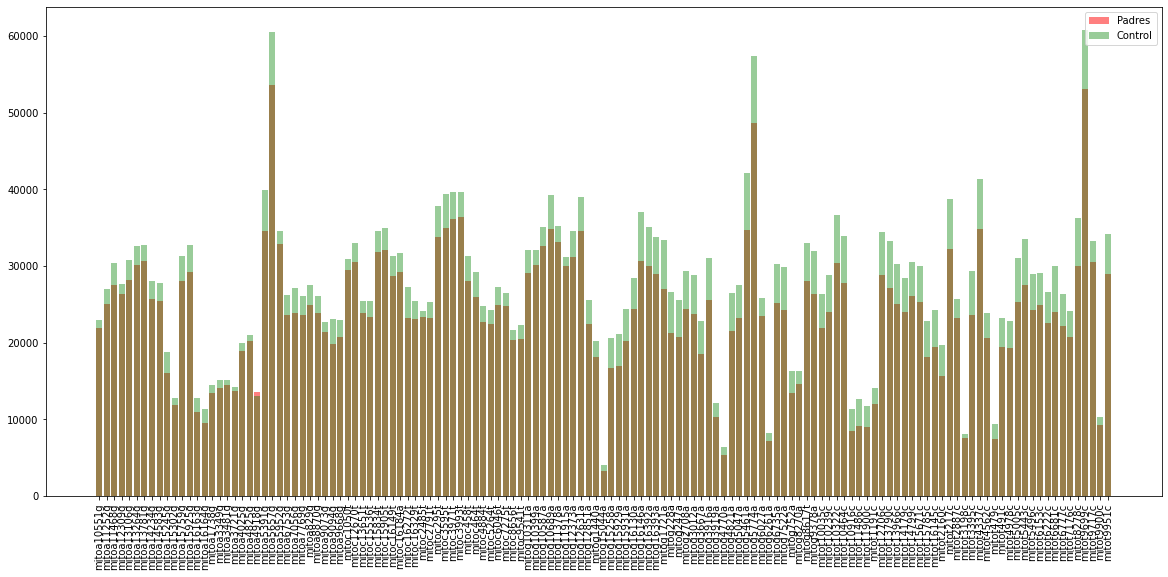

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


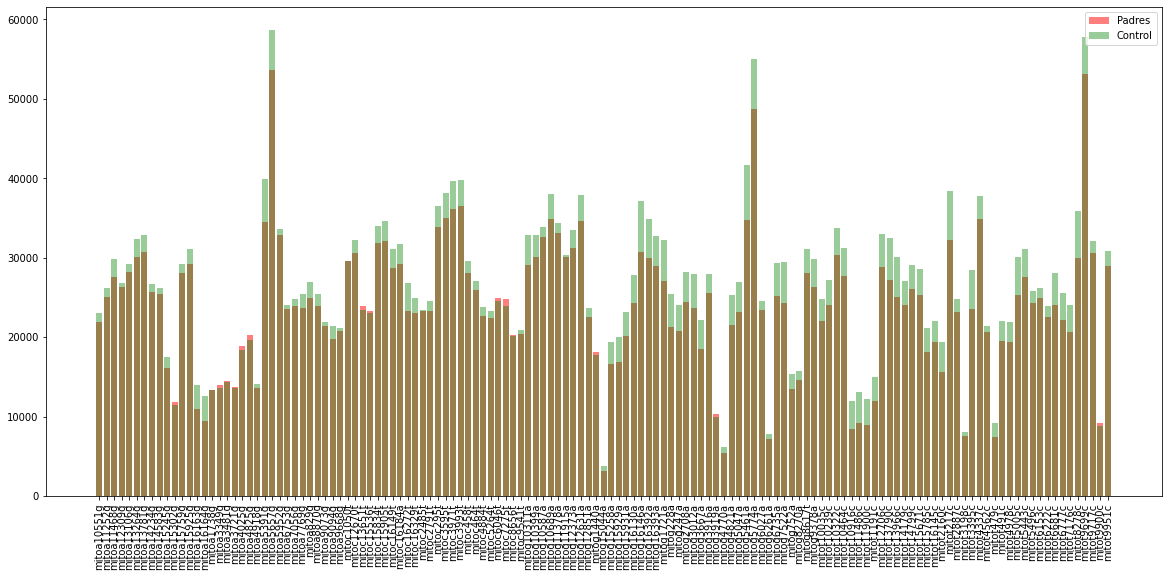

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


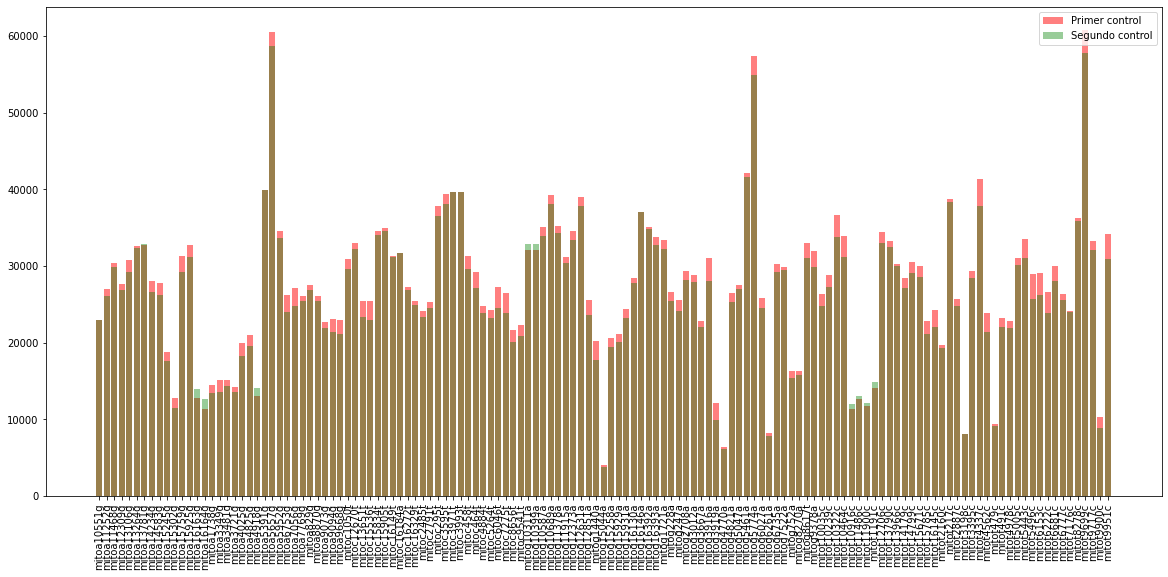

In [87]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#Releemos los datos de control y tríos, esta vez solo SNPs
#Primeros datos de control
x, y, data, control, nrx, ncx= readDataSuma('/content/drive/MyDrive/TFG/Autism/AutismDuoChrom26.iou','/content/drive/MyDrive/TFG/Autism/Human1M-Duov3_B_PosSortedChrom26.cols','/content/drive/MyDrive/TFG/NBS/WTCCC2_NBSChrom26.iou',
               '/content/drive/MyDrive/TFG/MS/WTCCC2_MS_Human670-QuadCustom_v1_APosSortedChrom26.cols')
#Segundos datos de control
x2, y2, data2, control2, nrx2, ncx2= readDataSuma('/content/drive/MyDrive/TFG/Autism/AutismDuoChrom26.iou','/content/drive/MyDrive/TFG/Autism/Human1M-Duov3_B_PosSortedChrom26.cols','/content/drive/MyDrive/TFG/BC/WTCCC2_BCChrom26.iou',
               '/content/drive/MyDrive/TFG/BC/Human1-2M-DuoCustom_v1_APosSortedChrom26.cols')

"""
Histogramas
"""
plt.rcParams["figure.figsize"] = (20,9)
fig = plt.figure()
ax1 = fig.add_subplot(111)
#Empiezo en 1 porque la columna 0 es el género
medias_padres=data.mean()[1:]
medias_control=control.mean()[1:]

plt.bar(medias_padres.index, medias_padres.values, alpha=0.5, color='r', label='Padres')
plt.xticks(rotation='vertical')
plt.bar(medias_control.index, medias_control.values, alpha=0.4, color='g', label='Control')
plt.xticks(rotation='vertical')
plt.legend(loc='upper right')
plt.show()

print()

plt.rcParams["figure.figsize"] = (20,9)
ax1 = fig.add_subplot(111)
#Empiezo en 1 porque la columna 0 es el género
medias_padres=data2.mean()[1:]
medias_control=control2.mean()[1:]

plt.bar(medias_padres.index, medias_padres.values, alpha=0.5, color='r', label='Padres')
plt.xticks(rotation='vertical')
plt.bar(medias_control.index, medias_control.values, alpha=0.4, color='g', label='Control')
plt.xticks(rotation='vertical')
plt.legend(loc='upper right')
plt.show()

print()

plt.rcParams["figure.figsize"] = (20,9)
ax1 = fig.add_subplot(111)
#Empiezo en 1 porque la columna 0 es el género
medias_control1=control.mean()[1:]
medias_control2=control2.mean()[1:]

plt.bar(medias_control1.index, medias_control1.values, alpha=0.5, color='r', label='Primer control')
plt.xticks(rotation='vertical')
plt.bar(medias_control2.index, medias_control2.values, alpha=0.4, color='g', label='Segundo control')
plt.xticks(rotation='vertical')
plt.legend(loc='upper right')
plt.show()



## T-Test de medias

### Con el primer control

In [54]:
from scipy.stats import ttest_ind
def t_test(x,y,alternative='both-sided'):
    tts, double_p = ttest_ind(x,y,equal_var = False)
    if alternative == 'both-sided':
        pval = double_p
    elif alternative == 'greater':
        if np.mean(x) > np.mean(y):
            pval = double_p/2.
        else:
            pval = 1.0 - double_p/2.
    elif alternative == 'less':
        if np.mean(x) < np.mean(y):
            pval = double_p/2.
        else:
            pval = 1.0 - double_p/2.
    return tts, pval

In [94]:
tt=[]
pv=[]
for i in range(0,data.shape[1]):
    w, p = t_test(data.iloc[:,i], control.iloc[:,i], 'less')
    tt.append(w)
    pv.append(p)

print(tt)
print(data.shape[1])

p_values = pd.Series(pv,index=ncx)
p_values.sort_values(ascending = False , inplace = True)
print(p_values)

[-3.363140861438127, -4.783498437735106, -6.1704169483976425, -10.933065815467566, -3.12980943365627, -10.286136787281949, -4.588438138295867, -7.322720335472937, -9.982737763274852, -9.782983745965133, -8.817464633789617, -7.496111118674539, -11.666916223853562, -13.01388391178941, -10.55605814124631, -13.004002635055286, -6.148536990339715, -6.7268546755490854, -2.9797246454988757, -3.403803476032384, -5.673431857151312, -3.9303075522669575, 2.3752305043817623, -18.964858602265426, -14.964842446894492, -5.525071272215411, -10.508750426282713, -14.057959388450996, -8.726963030164129, -9.581912960921656, -8.177276893638641, -5.5451342304122715, -13.039250387700992, -9.94029574787058, -4.479779219729587, -8.712407251587875, -5.6195792105215014, -9.525152836673383, -7.936623378296288, -10.159584779920811, -9.221631300558167, -9.474524470778464, -14.988725186929143, -10.01281308708377, -2.609785683157467, -8.988965355974477, -11.429229059788815, -14.258936968855657, -10.413500747872186, -

p-values muy bajos, no va a haber diferencias aleatorias entre control y datos

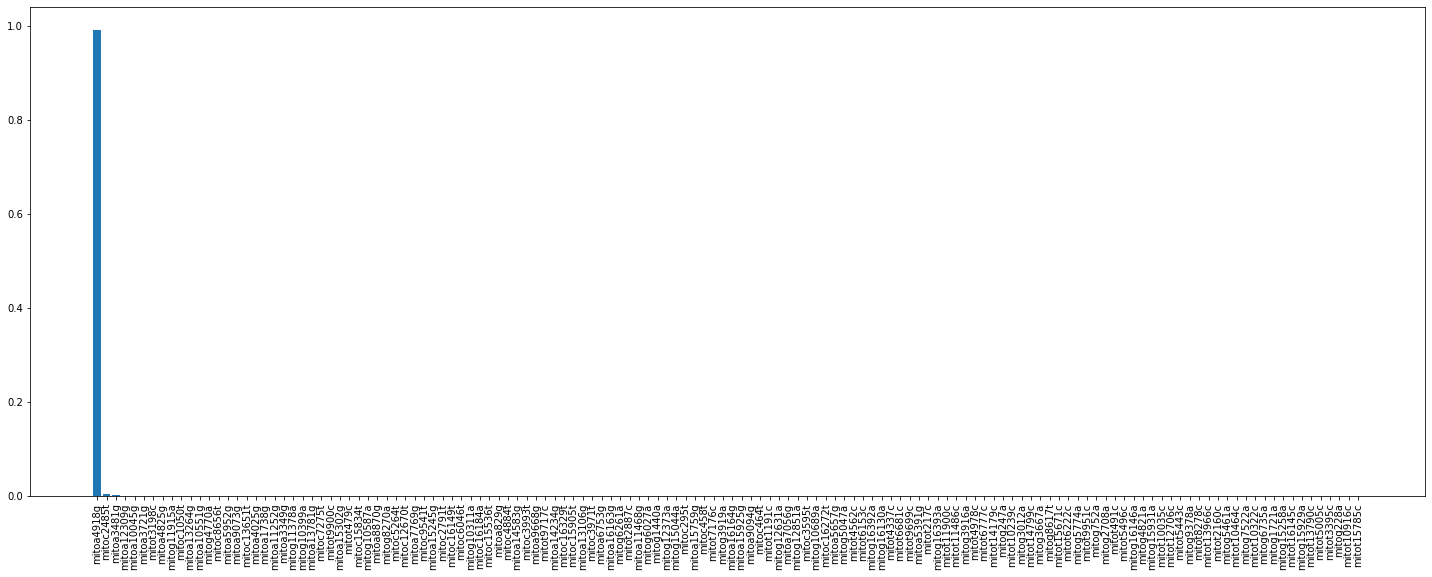

In [95]:
import matplotlib.pyplot as plt
#Grafica de los p-values
fig = plt.figure(figsize=(25, 9))
langs = p_values.index
plt.bar(langs,p_values)
plt.xticks(rotation=90)
plt.show()

In [96]:
THRESHOLD_P_VALUE = 0.05

mayores=0
for i in p_values:
  if i > THRESHOLD_P_VALUE:
    mayores+=1

print("Posiciones con p-values mayores que 0.05: ", mayores)
print(x.shape)

Posiciones con p-values mayores que 0.05:  1
(4427, 136)


### Con el segundo control

In [97]:
tt2=[]
pv2=[]
for i in range(0,data2.shape[1]):
    w, p = t_test(data2.iloc[:,i], control2.iloc[:,i], 'less')
    tt2.append(w)
    pv2.append(p)

print(tt2)
print(data2.shape[1])

p_values2 = pd.Series(pv2,index=ncx)
p_values2.sort_values(ascending = False , inplace = True)
print(p_values2)

[-2.3680066434269986, -4.849387651938875, -3.6071048121078144, -8.99746230305627, -1.1889840059007424, -4.078629355197339, -4.274460657035015, -7.548000045292316, -4.093380903818324, -3.0372191921316047, -5.024452403289459, 3.2501196248998316, -4.136685577729088, -7.036516901654414, -17.625041735385583, -21.546469177317746, 0.03228141341635124, 2.868137458197894, 1.0835099338706522, 1.1642048855088196, 2.883546110190144, 3.305833741869046, -2.219143436758438, -18.75527134289565, -10.955634522103022, -2.547044255699078, -1.7566675211602933, -3.7982139671331523, -6.356460968160182, -7.375656728090941, -5.648250398894957, -2.4628821493865063, -6.172504523846753, -1.468046234212275, -0.24388227240217492, -5.712362164463546, 1.7306034022075407, 1.4858931728396387, -6.325676623523361, -9.007877767183503, -8.49162794588808, -9.092206754173102, -13.197217267391423, -7.956918061808484, -0.30705925802114076, -5.479515663407774, -7.841713367746603, -10.361728891754789, -10.222953588555779, -10.18

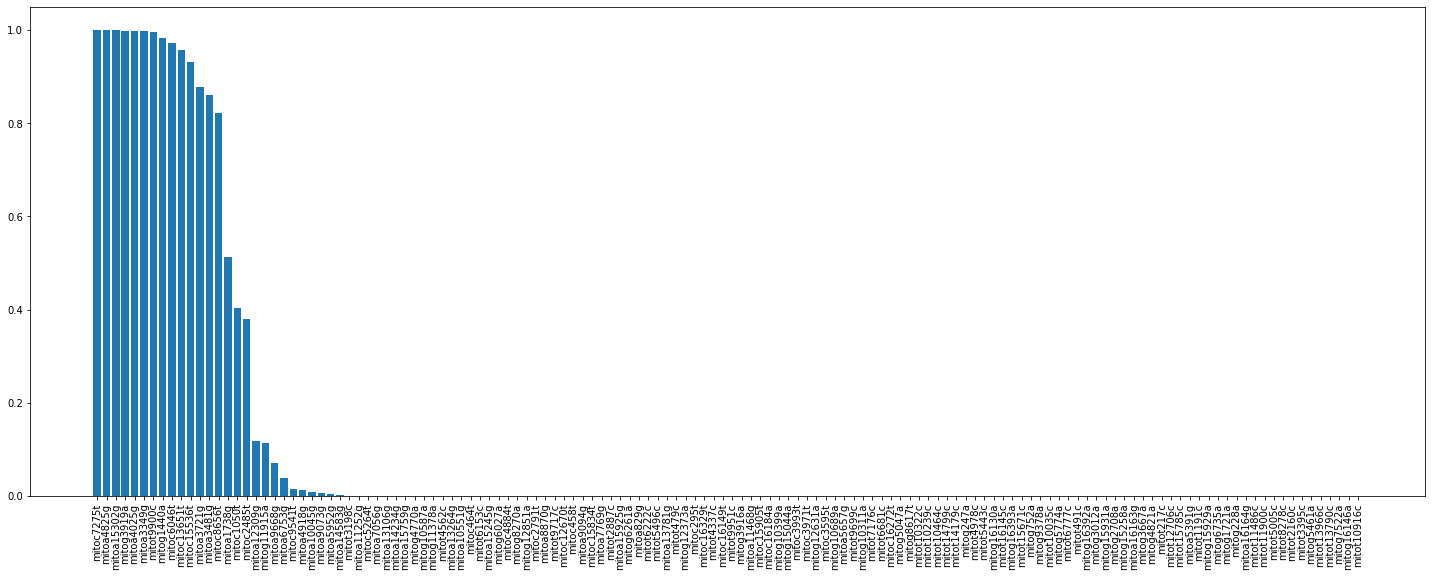

In [98]:
import matplotlib.pyplot as plt
#Grafica de los p-values
fig = plt.figure(figsize=(25, 9))
langs = p_values2.index
plt.bar(langs,p_values2)
plt.xticks(rotation=90)
plt.show()

In [99]:
THRESHOLD_P_VALUE = 0.05

mayores2=0
for i in p_values2:
  if i > THRESHOLD_P_VALUE:
    mayores2+=1

print("Posiciones con p-values mayores que 0.05: ", mayores2)
print(x2.shape)

Posiciones con p-values mayores que 0.05:  20
(4648, 136)


### Entre dos controles

In [100]:
from scipy import stats
tt2=[]
pv2=[]
for i in range(0,control.shape[1]):
    w, p = t_test(control.iloc[:,i], control2.iloc[:,i], 'greater')
    tt2.append(w)
    pv2.append(p)

print(tt2)
print(control.shape[1])

p_values2 = pd.Series(pv2,index=ncx)
p_values2.sort_values(ascending = False , inplace = True)
print(p_values2)

[1.3467318016694325, -0.12112032724604505, 3.1773362712635147, 2.694835642455166, 2.235122415273217, 8.15157597644606, 0.5001724761395029, -0.3333008134915684, 7.847004602184025, 9.188020425350986, 4.460366521488846, 14.433856687880544, 10.961080188642153, 8.443951748687025, -9.818434228067563, -11.819673834252635, 7.819118613192755, 13.24452664970107, 5.033461154206232, 6.4445274747040715, 11.509839831875066, 9.957415485905287, -8.340850209857607, -0.10572021706056225, 5.156693122578112, 4.307566780636015, 11.030067807884082, 13.83788227511578, 2.893723388175836, 2.984368915009497, 3.397674248889979, 4.22516789488676, 10.42433107606016, 12.349826271098165, 6.6998551256880425, 4.265393122695814, 9.689156146160206, 15.123149628286154, 2.1435210438166976, 1.6302483318864143, 1.0087031958417778, 0.5019876654876703, 2.45954944662222, 2.8931307856196904, 3.277565044031462, 4.9793771125497, 4.692921790227044, 5.439529155796946, 0.1431795222622452, -0.542798295648838, 8.0444359817336, 11.5636

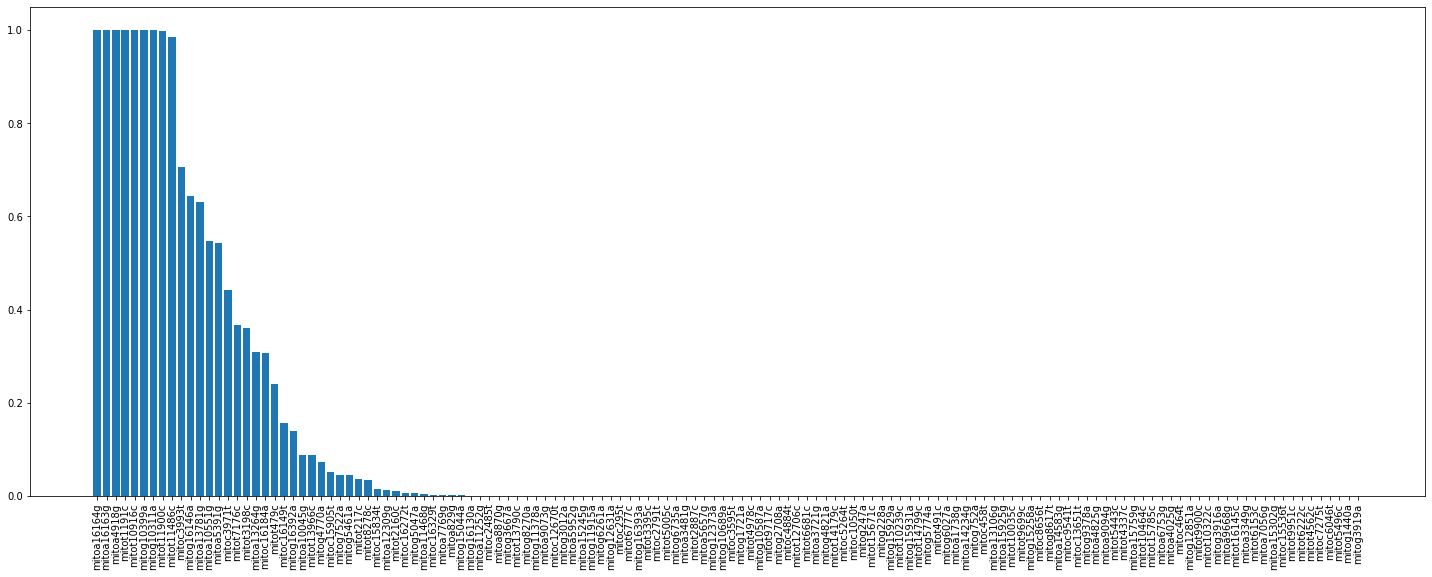

In [101]:
import matplotlib.pyplot as plt
#Grafica de los p-values
fig = plt.figure(figsize=(25, 9))
langs = p_values2.index
plt.bar(langs,p_values2)
plt.xticks(rotation=90)
plt.show()

In [102]:
THRESHOLD_P_VALUE = 0.05

mayores2=0
for i in p_values2:
  if i > THRESHOLD_P_VALUE:
    mayores2+=1

print("Posiciones con p-values mayores que 0.05: ", mayores2)
print(x2.shape)

Posiciones con p-values mayores que 0.05:  26
(4648, 136)


## Test de Wilcoxon

### Con el primer control

In [109]:
from scipy.stats import wilcoxon
wix=[]
pv=[]

w, p = wilcoxon(medias_padres, medias_control1, alternative='less')
wix.append(w)
pv.append(p)

print(wix)
print(control.shape[1])

print(p)

[1.0]
136
3.432881726867435e-24


### Con el segundo control

In [110]:
from scipy.stats import wilcoxon
wix=[]
pv=[]

w, p = wilcoxon(medias_padres, medias_control2, alternative='less')
wix.append(w)
pv.append(p)

print(wix)
print(control.shape[1])

print(p)

[198.0]
136
2.5556890490346657e-22


### Entre controles

In [115]:
from scipy.stats import wilcoxon
wix=[]
pv=[]

w, p = wilcoxon(medias_control1, medias_control2, alternative='greater')
wix.append(w)
pv.append(p)

print(wix)
print(control.shape[1])

print(p)

[8735.0]
136
4.372679683370061e-20
